In [1]:
%load_ext autoreload
%autoreload 2

In [43]:
import os
import warnings
warnings.filterwarnings("ignore")

import sys
from pathlib import Path

sys.path.append("../")

import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm
from phik import phik_matrix
import matplotlib.pyplot as plt
from mlflow.tracking import MlflowClient
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split

from scripts import logger
from scripts.env import env_vars
from scripts.utils_mlflow import get_experiment_id
from scripts.utils import (
    read_table_from_db,
    get_bins,
    read_yaml,
    compare_distributions,
    reduce_size,
    save_yaml,
)
from scripts.plotters import (
    custom_hist_multiplot,
    custom_joint_plot,
    custom_box_multiplot,
    custom_violin_multiplot,
)

pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

sns.set_style("dark")
sns.set_theme(style="darkgrid", palette="deep")


In [3]:
RUN_NAME_EDA = 'eda'

# I. Some preparations

Setting up tracking uri and registery uri with a Mlflow client

In [4]:
mlflow.set_tracking_uri(f"http://{env_vars.tracking_server_host}:{env_vars.tracking_server_port}")
mlflow.set_registry_uri(f"http://{env_vars.tracking_server_host}:{env_vars.tracking_server_port}")

client = MlflowClient()

Loading config file and the cleaned data from the remote database

In [5]:
config = read_yaml(Path(f"{env_vars.config_dir}/config.yaml"))

df = read_table_from_db(table_name=config['raw_table_name'])
reduce_size(df)

2024-09-18 21:24:24,663 - mlflow_project - INFO - YAML file ../config/config.yaml has been loaded


2024-09-18 21:24:26,006 - mlflow_project - INFO - Table cleaned_flats has been loaded
Dataframe memory usage before optimisation: 15.57243824005127 MB


  0%|          | 0/19 [00:00<?, ?it/s]

Dataframe memory usage after optimisation: 5.824881553649902 MB


Splitting data into train and test subsets with a stratification approach.  
Since it is a regression problem, the target column is binned into several bins  
and the resulting column is used for stratification.

In [6]:
df, df_test = train_test_split(
    df,
    test_size=config["data_split_config"]["test_size"],
    random_state=config["data_split_config"]["random_state"],
    stratify=pd.qcut(df[config["target_col"]], 10, labels=False),
    shuffle=True,
)
df["subset"] = "train"
df_test["subset"] = "test"
df = pd.concat([df, df_test], axis=0)

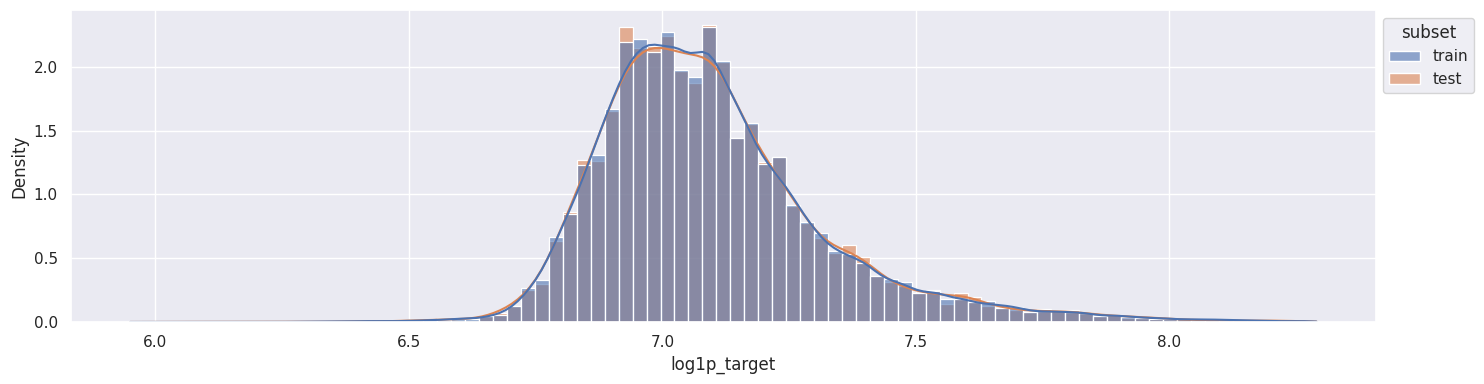

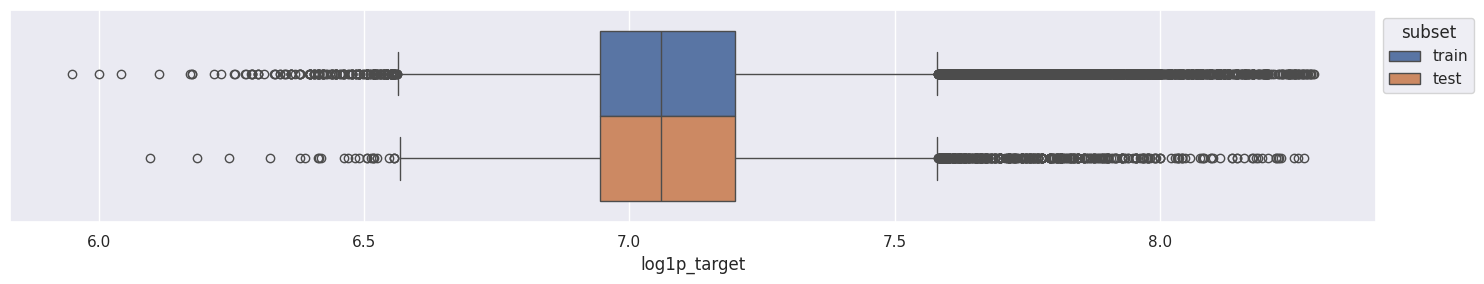

feature   hue1  hue2  significance_level  ks_2samp.pv   
0  log1p_target  train  test                0.05     0.999411  \

   anderson_ksamp.pv  mannwhitneyu.pv  ranksums.pv  ks_2samp.similar   
0               0.25         0.897535     0.897537              True  \

   anderson_ksamp.similar  mannwhitneyu.similar  ranksums.similar  
0                    True                  True              True

In [7]:
custom_hist_multiplot(data=df, columns=[config['target_col']], hue='subset', features_kind='num')
custom_box_multiplot(data=df, columns=[config['target_col']], hue='subset')
compare_distributions(data=df, features=[config['target_col']], hue='subset', are_categorical=False)

It can be seen, that the distribution of the target column in the train subset is similar to one on the test subset according to the histogram and statistical tests.

In [8]:
train_bins = get_bins(len(df.query("subset == 'train'")))
test_bins = get_bins(len(df.query("subset == 'test'")))
train_bins, test_bins

(82, 39)

# II. EDA

## 2.1. Dataset overview

To begin with, the problem of duplicates, missing data and outliers is covered in the data cleaning stage which was done earlier.  
As a result, no missing data was found, the duplicates were removed and only most extreme outliers were removed (otherwise a lot of data would be lost).  

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124647 entries, 106691 to 77829
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 124647 non-null  uint32 
 1   flat_id            124647 non-null  uint32 
 2   floor              124647 non-null  uint8  
 3   is_apartment       124647 non-null  bool   
 4   kitchen_area       124647 non-null  float32
 5   living_area        124647 non-null  float32
 6   rooms              124647 non-null  uint8  
 7   total_area         124647 non-null  float32
 8   log1p_target       124647 non-null  float32
 9   building_id        124647 non-null  uint16 
 10  build_year         124647 non-null  uint16 
 11  building_type_int  124647 non-null  uint8  
 12  latitude           124647 non-null  float32
 13  longitude          124647 non-null  float32
 14  ceiling_height     124647 non-null  float32
 15  flats_count        124647 non-null  uint16 
 16  flo

As for data types, categorical and numerical features are sufficiently represented

In [10]:
df.query('subset == "train"').describe()

id        flat_id          floor   kitchen_area   
count  1.121820e+05  112182.000000  112182.000000  112182.000000  \
mean   1.301171e+06   70210.997647       7.189380       8.668926   
std    3.596401e+04   41125.326286       5.077862       4.138067   
min    1.238856e+06       0.000000       1.000000       0.000000   
25%    1.270064e+06   34264.250000       3.000000       6.100000   
50%    1.301170e+06   70599.500000       6.000000       8.600000   
75%    1.332300e+06  105774.750000      10.000000      10.100000   
max    1.363501e+06  141361.000000      31.000000      35.000000   

         living_area          rooms     total_area   log1p_target   
count  112182.000000  112182.000000  112182.000000  112182.000000  \
mean       29.290640       2.046817      56.900505       7.095891   
std        17.729023       0.880370      23.724426       0.225022   
min         0.000000       1.000000      11.000000       5.950098   
25%        19.000000       1.000000      39.000000       6.944483   
50%        29.000000       2.000000      52.000000       7.060698   
75%        40.000000       3.000000      66.400002       7.199206   
max       150.000000       6.000000     195.199997       8.289836   

         building_id     build_year  building_type_int       latitude   
count  112182.000000  112182.000000      112182.000000  112182.000000  \
mean    13829.426307    1986.131679           3.324241      55.730377   
std      6810.678167      20.860766           1.444048       0.103398   
min       230.000000    1914.000000           0.000000      55.427238   
25%      8479.250000    1969.000000           2.000000      55.652420   
50%     13927.000000    1983.000000           4.000000      55.721611   
75%     19943.000000    2006.000000           4.000000      55.810081   
max     24617.000000    2022.000000           6.000000      56.011032   

           longitude  ceiling_height    flats_count   floors_total  
count  112182.000000   112182.000000  112182.000000  112182.000000  
mean       37.591061        2.728159     240.282621      13.673620  
std         0.152027        0.172388     164.239212       5.799448  
min        37.104614        2.250000       1.000000       1.000000  
25%        37.491253        2.640000     112.000000       9.000000  
50%        37.582565        2.640000     199.000000      14.000000  
75%        37.703575        2.800000     320.000000      17.000000  
max        37.946411        3.400000     952.000000      41.000000

Since the target features was transformed via log1p transformation, we need to reverse the transformation to get the actual values 
in order to perform some analysis

In [11]:
(10**df.query('subset == "train"')[config['target_col']] - 1).describe()

count    1.121820e+05
mean     1.478956e+07
std      1.261066e+07
min      8.914502e+05
25%      8.800001e+06
50%      1.150000e+07
75%      1.582000e+07
max      1.949108e+08
Name: log1p_target, dtype: float64

1. latitude & longitude
    average coordinates and their min and max values suggest that all buildings are located in the Moscow or very close to it.
2. build_year - the average build year is about 1983-1986  
    This is not a surprise since a lot of residential buildings in Moscow were built around the 80s
3. floor - an average floor is 6 or 7
4. Area feautures:  
    kitchen_area - avg value is about 8.6 $m^2%$  
    living_area - avg value is about 29 $m^2%$  
    total_area - avg value is about 52-57 $m^2%$   
    So, the avg values are reasonable - the kitchen are is quite small, while the living area takes slightly more than half of the total area.
5. building_type_int  
    the most common building type is 4, although the nature of the building type is not clear since it is encoded
6. ceiling_height - the average ceiling height is about 2.6-2.7m.  
    What is interesting, is that the median value 2.64 m is a common feature for residential buildings built in the 70s and 80s.
7. flats_count - the average number of flats is about 240.  
8. floors_total - the average number of floors is about 14-17, which is also a common feature for residential buildings built in the 80s.
9. target (log1p_price) - the average price is about 15 million rubles, which is quite reasonable for overall high prices in Moscow.

So an average flat was built in the 80s, with all corresponding features of the residential buildings built in the 80s.
It costs about 15 million rubles


## 2.2. Feature analysis

### latitude & longitude

2024-09-18 21:24:35,250 - mlflow_project - INFO - custom_joint_plot saved to ../artifacts/eda/latitude_longitude_jointplot.png


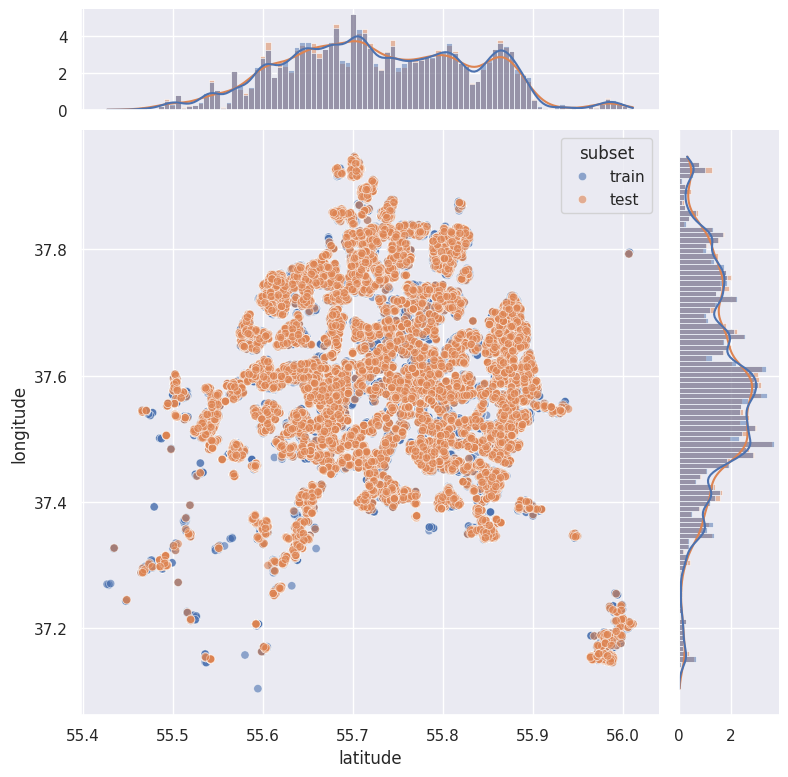

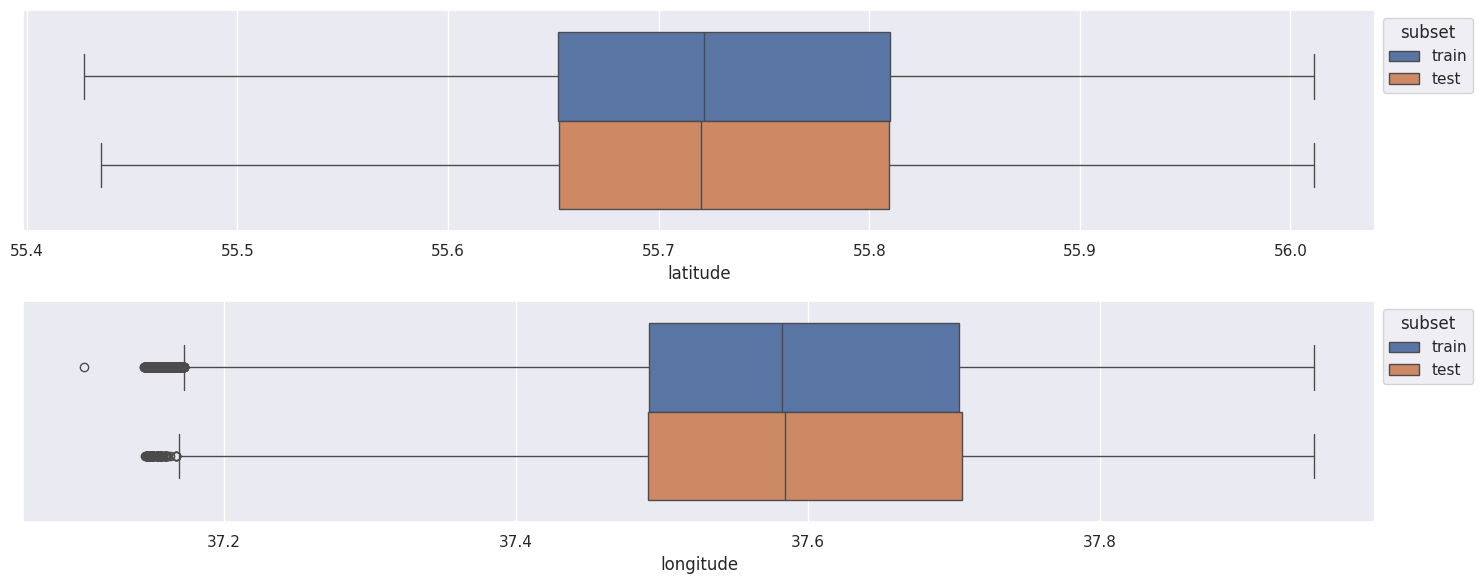

feature   hue1  hue2  significance_level  ks_2samp.pv  anderson_ksamp.pv   
0   latitude  train  test                0.05     0.814823               0.25  \
1  longitude  train  test                0.05     0.816306               0.25   

   mannwhitneyu.pv  ranksums.pv  ks_2samp.similar  anderson_ksamp.similar   
0         0.327463     0.327463              True                    True  \
1         0.551746     0.551746              True                    True   

   mannwhitneyu.similar  ranksums.similar  
0                  True              True  
1                  True              True

In [12]:
custom_joint_plot(data=df, x="latitude", y="longitude", hue='subset', savepath=Path(os.path.join(env_vars.eda_artifacts_dir, 'latitude_longitude_jointplot.png')))
custom_box_multiplot(data=df, columns=['latitude', 'longitude'], hue='subset')
compare_distributions(data=df, features=['latitude', 'longitude'], hue='subset', are_categorical=False)

According to the jointplot, it is clear, that it is Moscow.  
The distribution of both coordinates looks more or less symmetrical.   
If to consider a train and test datasets separately, we can see that the corresponding distritions are similar according to the jointplot and statistical tests.  
It would be a good idea to create a new feature, which would indicate how far the flat is from the center of the city or from the nearest metro station.

### build_year

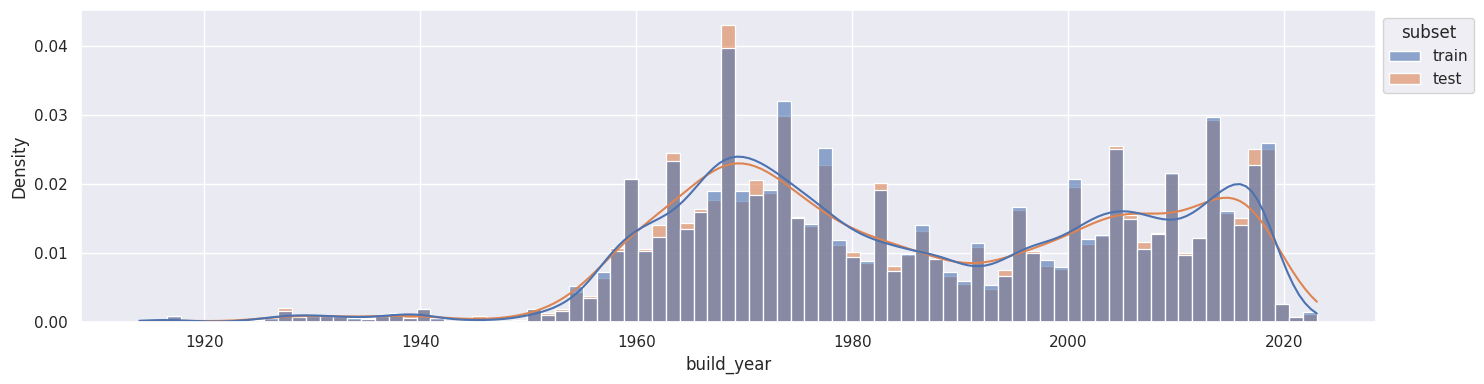

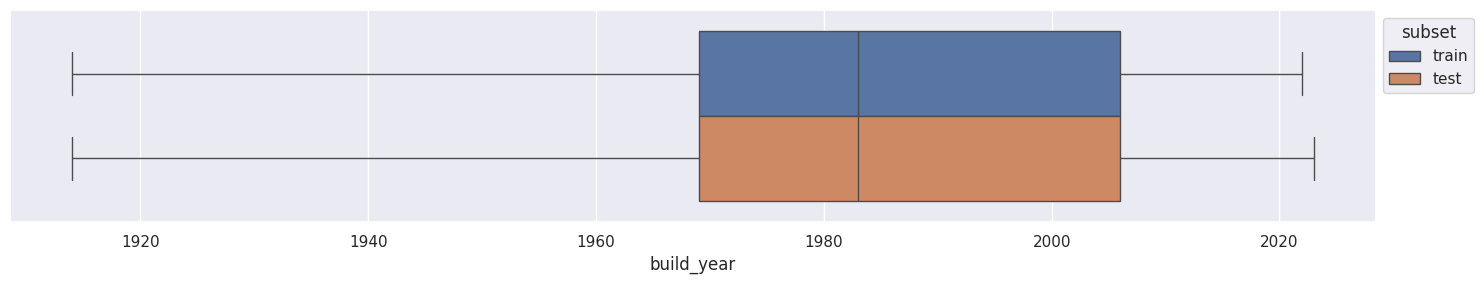

feature   hue1  hue2  significance_level  ks_2samp.pv   
0  build_year  train  test                0.05     0.526756  \

   anderson_ksamp.pv  mannwhitneyu.pv  ranksums.pv  ks_2samp.similar   
0               0.25          0.79363     0.793661              True  \

   anderson_ksamp.similar  mannwhitneyu.similar  ranksums.similar  
0                    True                  True              True

In [13]:
custom_hist_multiplot(data=df, columns=['build_year'], hue='subset', features_kind='num')
custom_box_multiplot(data=df, columns=['build_year'], hue='subset')
compare_distributions(data=df, features=['build_year'], hue='subset', are_categorical=False)

According to the histplot, there are 3 different distributions of the build_year:
- earlier than 1950 - group of very old buildingg, which were mostly built prior to the WW2
- between 1950 and 1990 - this group represents soviet residential buildings (normal-like distribution)
- between 1990 and 2020 - this group represents new post-soviet residential buildings (right-skewed distribution)
It might be a good idea to create a new feature, which would indicate to which build_year group the flat belongs.

The distribution of the build_year is similar if to compare train and test subsets.

### kitchen_area, living_area, total_area

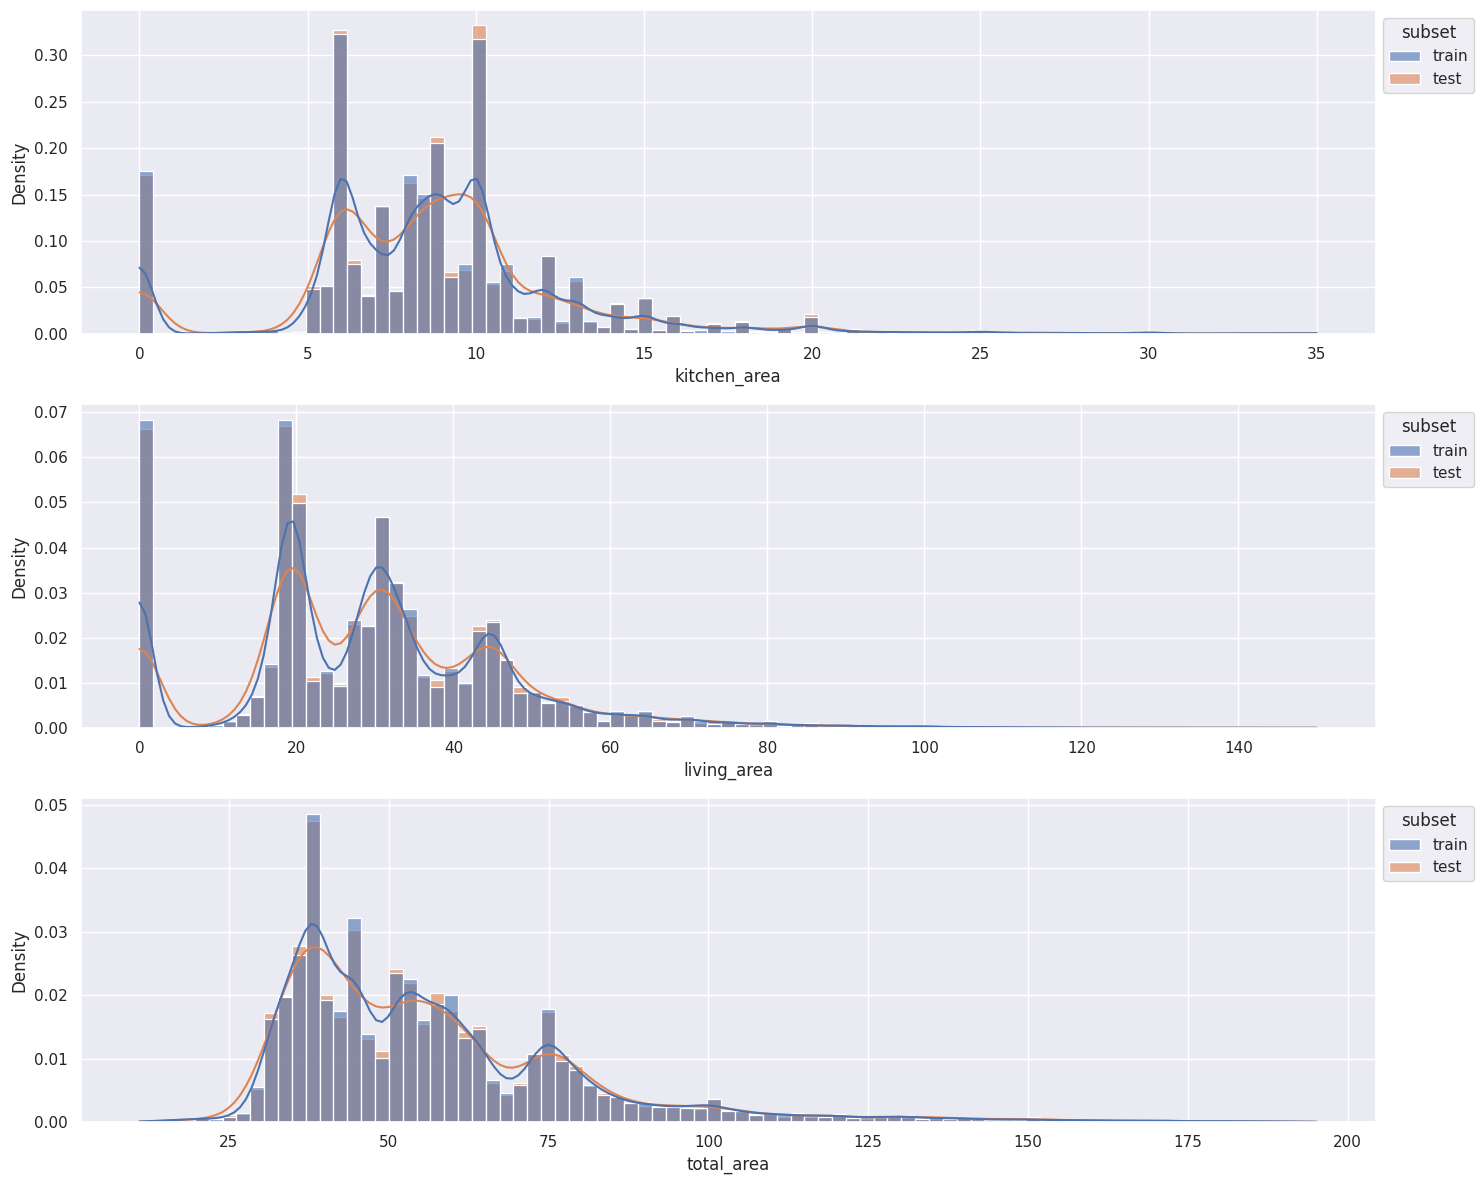

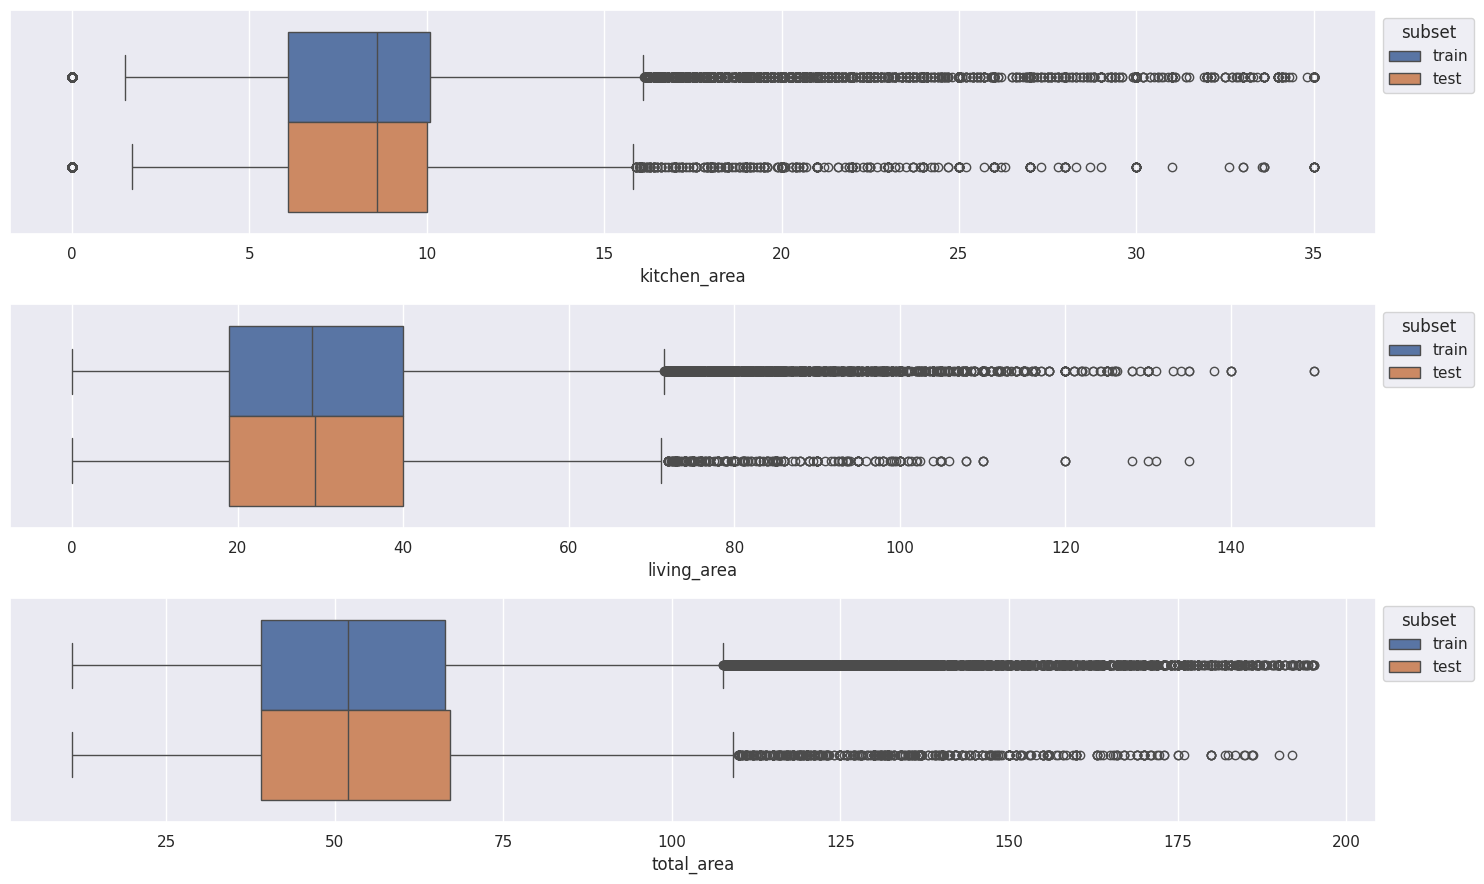

feature   hue1  hue2  significance_level  ks_2samp.pv   
0  kitchen_area  train  test                0.05     0.893009  \
1   living_area  train  test                0.05     0.453881   
2    total_area  train  test                0.05     0.886868   

   anderson_ksamp.pv  mannwhitneyu.pv  ranksums.pv  ks_2samp.similar   
0               0.25         0.834859     0.835147              True  \
1               0.25         0.207855     0.208303              True   
2               0.25         0.979885     0.979886              True   

   anderson_ksamp.similar  mannwhitneyu.similar  ranksums.similar  
0                    True                  True              True  
1                    True                  True              True  
2                    True                  True              True

In [14]:
cols = ['kitchen_area', 'living_area', 'total_area']
custom_hist_multiplot(data=df, columns=cols, hue='subset', features_kind='num')
custom_box_multiplot(data=df, columns=cols, hue='subset')
compare_distributions(data=df, features=cols, hue='subset', are_categorical=False)

It can be seen that there are quite a lot of 0 values in living_area and kitchen_area columns.  
Since there are no 0 values in the total_area column, it is highly unlikely that there was any  
error during data collection which led to 0 values in the area-related columns.  
The probable reason for the 0 values in the living_area and kitchen_area columns is that  
these properties are used for commercial purposes.

Therefore, it would be a good idea to make an indicator column which will indicate whether  
the value is 0 (for both living_area and kitchen_area).

Let's create a new feature and analyse the distribution with this feature

In [15]:
df['is_zero_kitchen_and_living_area'] = (df['kitchen_area'] == 0) & (df['living_area'] == 0)

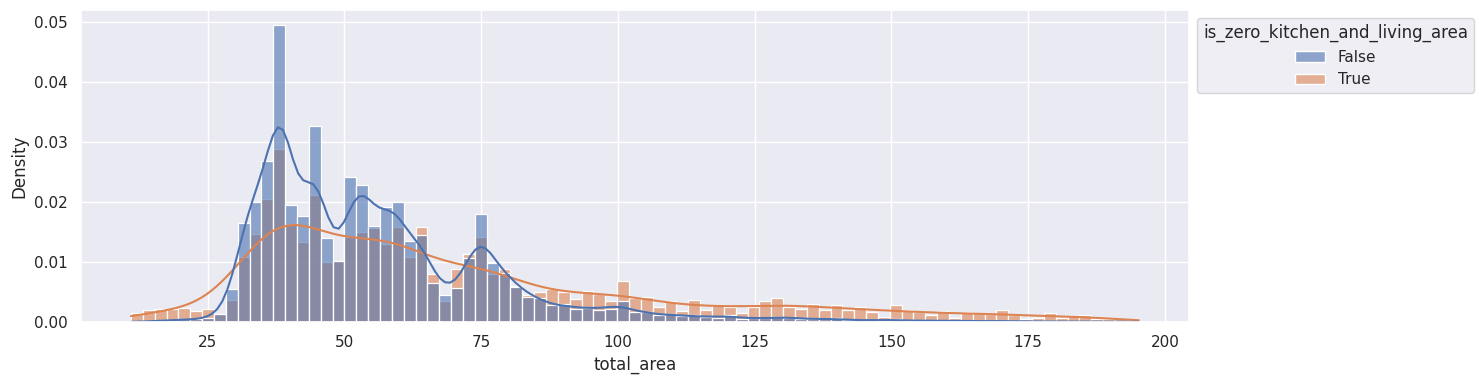

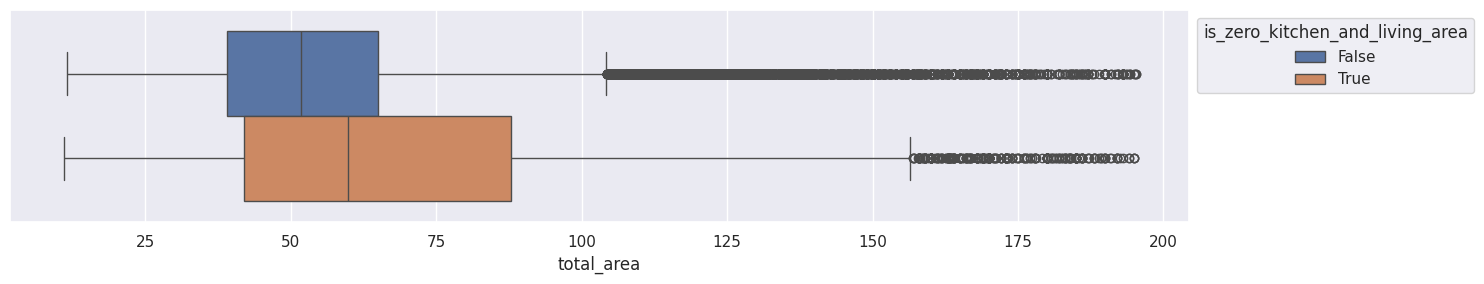

In [16]:
custom_hist_multiplot(data=df, columns=['total_area'], hue='is_zero_kitchen_and_living_area', features_kind='num')
custom_box_multiplot(data=df, columns=['total_area'], hue='is_zero_kitchen_and_living_area')

It is clear, that if both kitchen_area and living_area are 0, then the total_area tends to be bigger.  
To be precise, there are more bigger properties, which are commonly designed for commercial purposes,  
and more smaller properties (less than 25 $m^2$), which are usually small studios with no pre-designed living or kitchen area.

Now, let's analyse the distribution of the areas without 0 values.

2024-09-18 21:24:58,639 - mlflow_project - INFO - custom_joint_plot saved to ../artifacts/eda/living_area_total_area_jointplot.png


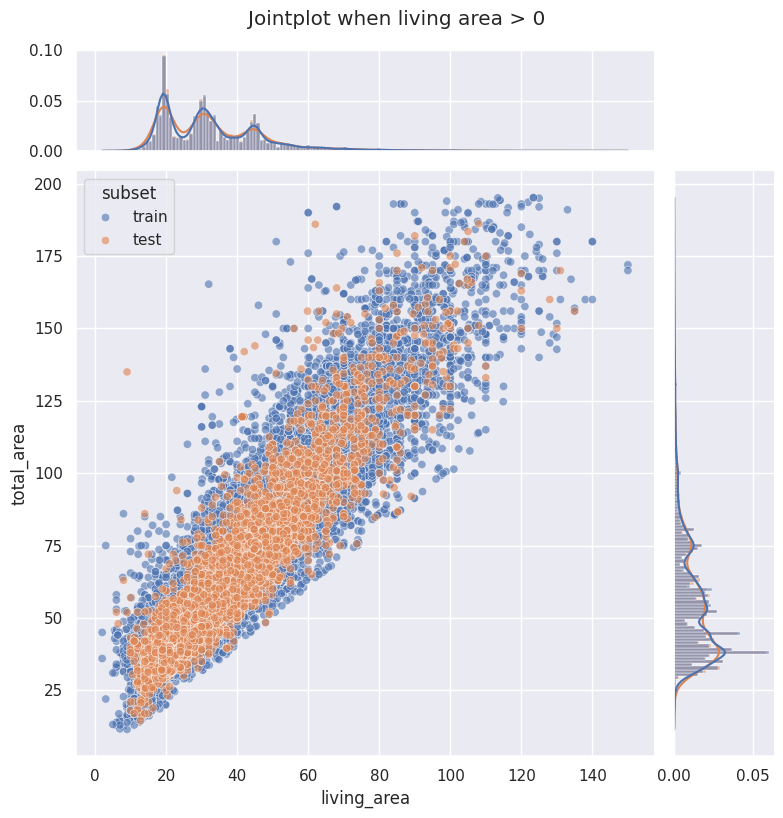

In [17]:
custom_joint_plot(
    data=df.query("living_area > 0"),
    x="living_area",
    y="total_area",
    hue="subset",
    title="Jointplot when living area > 0",
    savepath=Path(
        os.path.join(
            env_vars.eda_artifacts_dir, "living_area_total_area_jointplot.png"
        )
    ),
)


1. There are 3 peaks in the distribution of living_area - at about 20 $m^2$, 30 $m^2$ and 45 $m^2$.
2. There is a clear correlation between total_area and living_area - the more total_area, the more living_area.

2024-09-18 21:25:10,736 - mlflow_project - INFO - custom_joint_plot saved to ../artifacts/eda/kitchen_area_total_area_jointplot.png


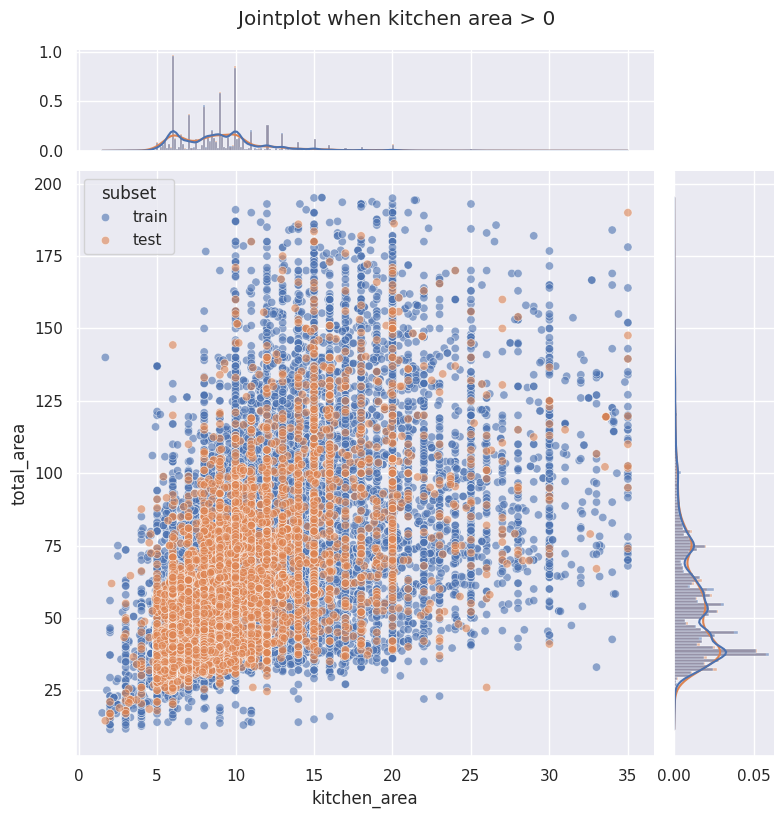

In [18]:
custom_joint_plot(
    data=df.query("kitchen_area > 0"),
    x="kitchen_area",
    y="total_area",
    hue="subset",
    title="Jointplot when kitchen area > 0",
    savepath=Path(
        os.path.join(
            env_vars.eda_artifacts_dir,
            "kitchen_area_total_area_jointplot.png",
        )
    ),
)


1. There are 3 peaks in the distribution of kitchen_area - at about 6 $m^2$, 8 $m^2$ and 10 $m^2$.
2. There is a correlation between total_area and kitchen_area - the more total_area, the more kitchen_area.  
    However, the cloud is not very dense being close to the line y=x and the values are highly scattered.

### ceiling_height

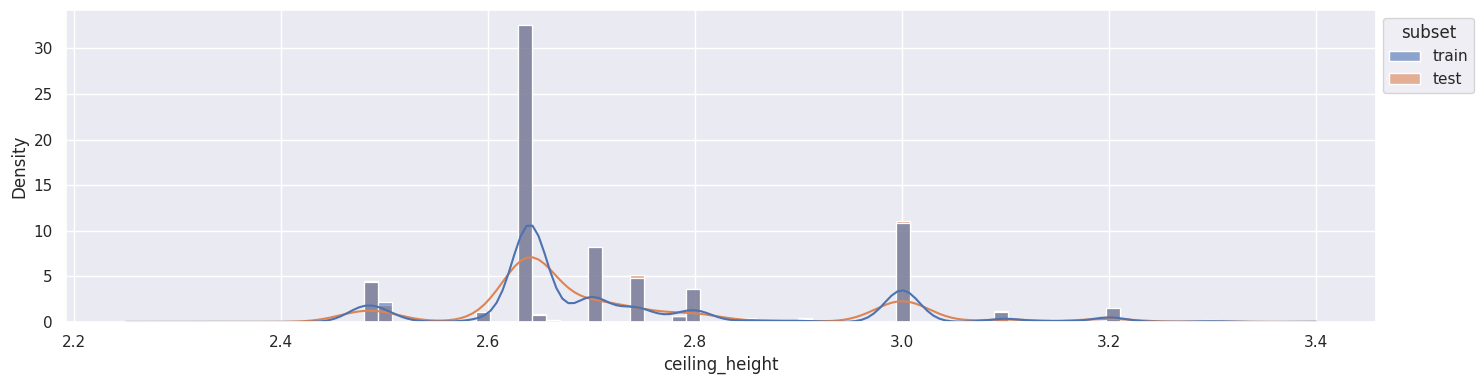

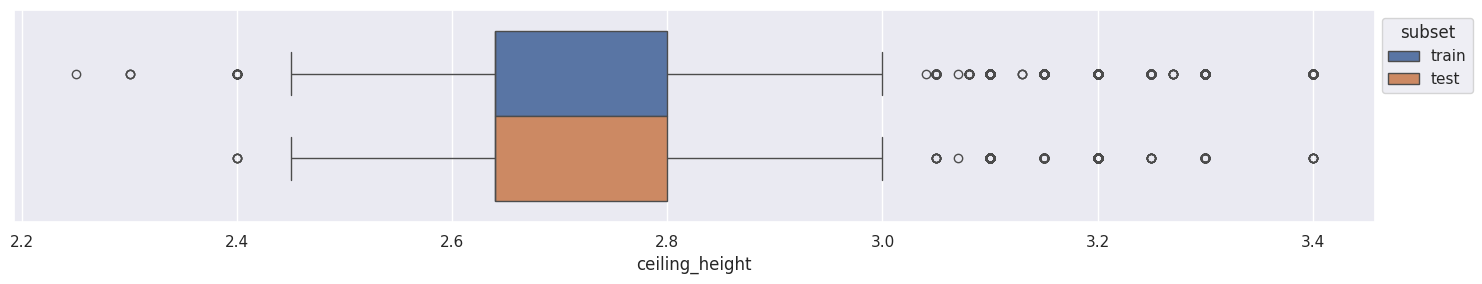

feature   hue1  hue2  significance_level  ks_2samp.pv   
0  ceiling_height  train  test                0.05     0.965906  \

   anderson_ksamp.pv  mannwhitneyu.pv  ranksums.pv  ks_2samp.similar   
0               0.25         0.220766     0.242903              True  \

   anderson_ksamp.similar  mannwhitneyu.similar  ranksums.similar  
0                    True                  True              True

In [19]:
custom_hist_multiplot(data=df, columns=['ceiling_height'], hue='subset', features_kind='num')
custom_box_multiplot(data=df, columns=['ceiling_height'], hue='subset')
compare_distributions(data=df, features=['ceiling_height'], hue='subset', are_categorical=False)

In [20]:
df['ceiling_height'].value_counts().head()

ceiling_height
2.64    54901
3.00    18303
2.70    13921
2.48     7465
2.74     6309
Name: count, dtype: int64

1. The distribution is discrete, which is not a surprise, since the height of a flat is usually the same among a group of flats.
2. The distribution is similar if to compare train and test subsets.
3. The most common value is 2.64, which is typical for residential buildings of the 70s and 80s.

### flats_count

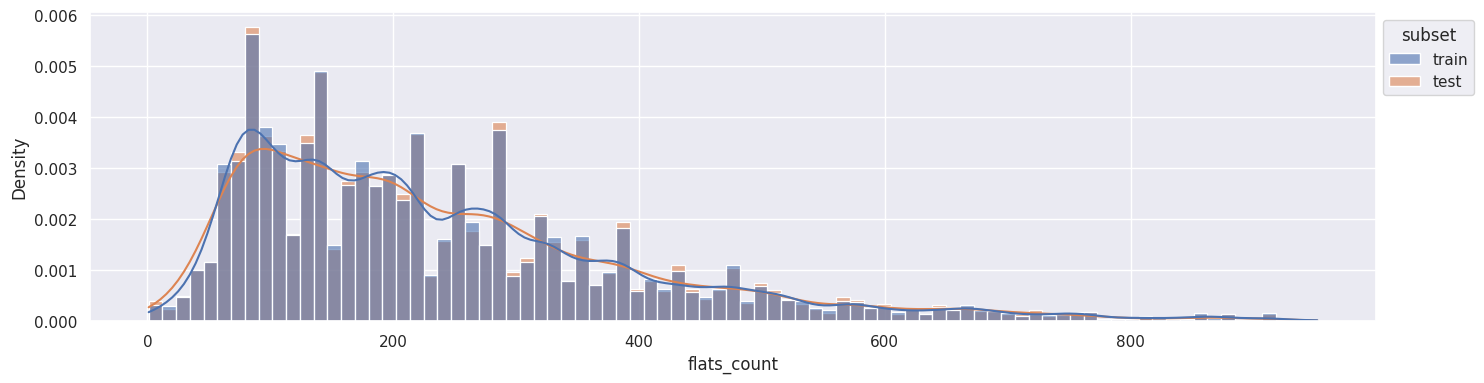

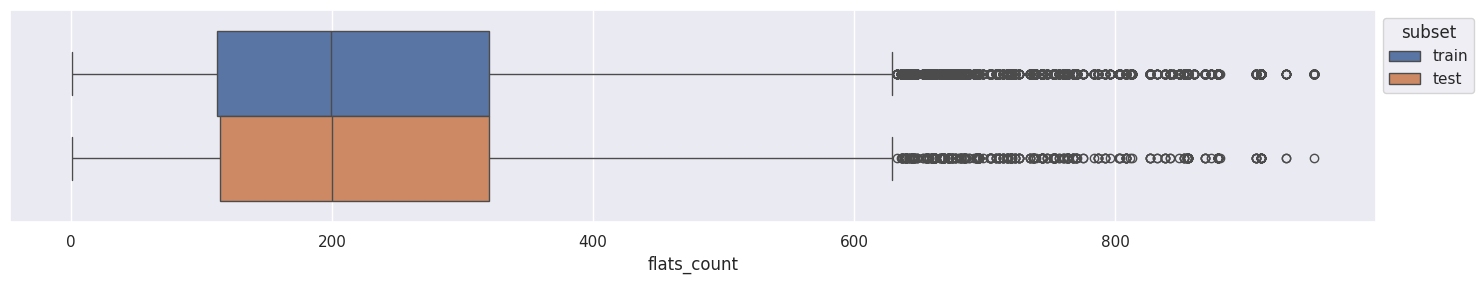

feature   hue1  hue2  significance_level  ks_2samp.pv   
0  flats_count  train  test                0.05     0.997098  \

   anderson_ksamp.pv  mannwhitneyu.pv  ranksums.pv  ks_2samp.similar   
0               0.25         0.917983     0.917986              True  \

   anderson_ksamp.similar  mannwhitneyu.similar  ranksums.similar  
0                    True                  True              True

In [21]:
custom_hist_multiplot(data=df, columns=['flats_count'], hue='subset', features_kind='num')
custom_box_multiplot(data=df, columns=['flats_count'], hue='subset')
compare_distributions(data=df, features=['flats_count'], hue='subset', are_categorical=False)

1. The distribution is skewed to the left, so it is more likely to see a medium-sized building
2. The distribution is similar if to compare train and test subsets.

### floor & floors_total

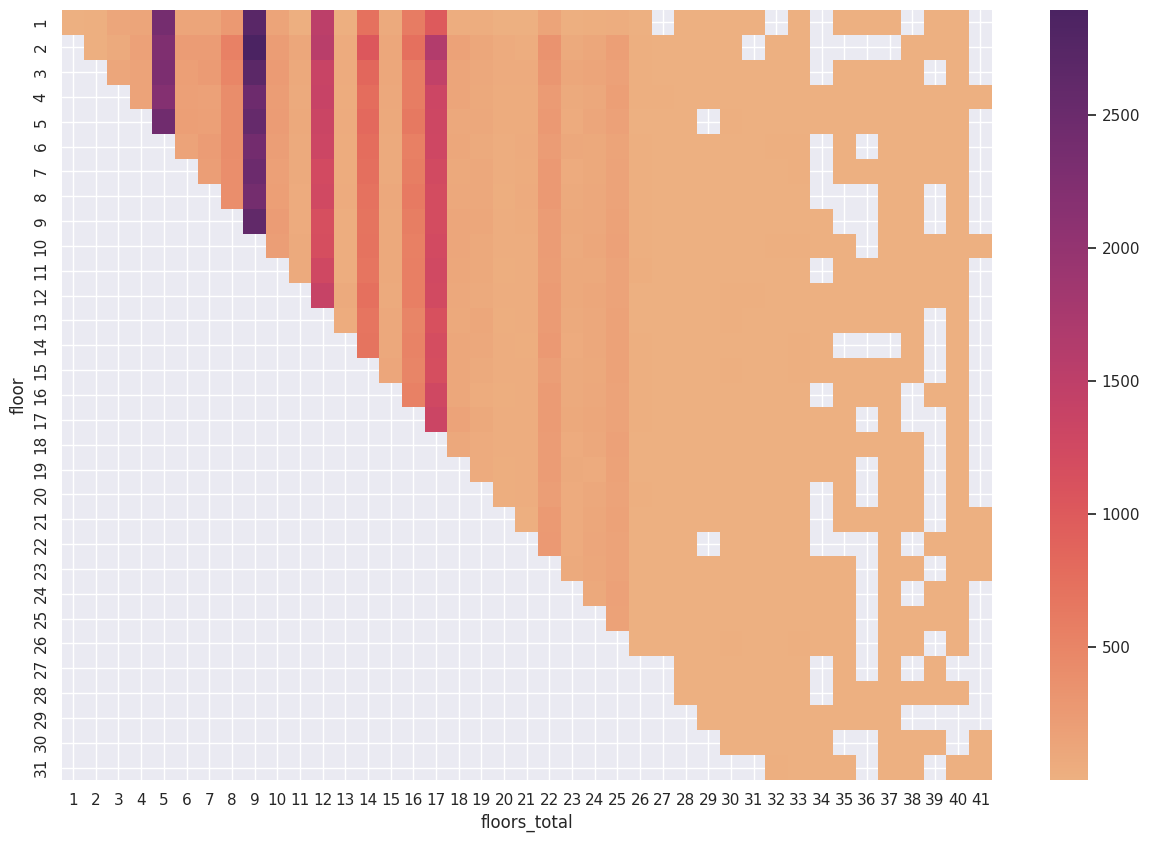

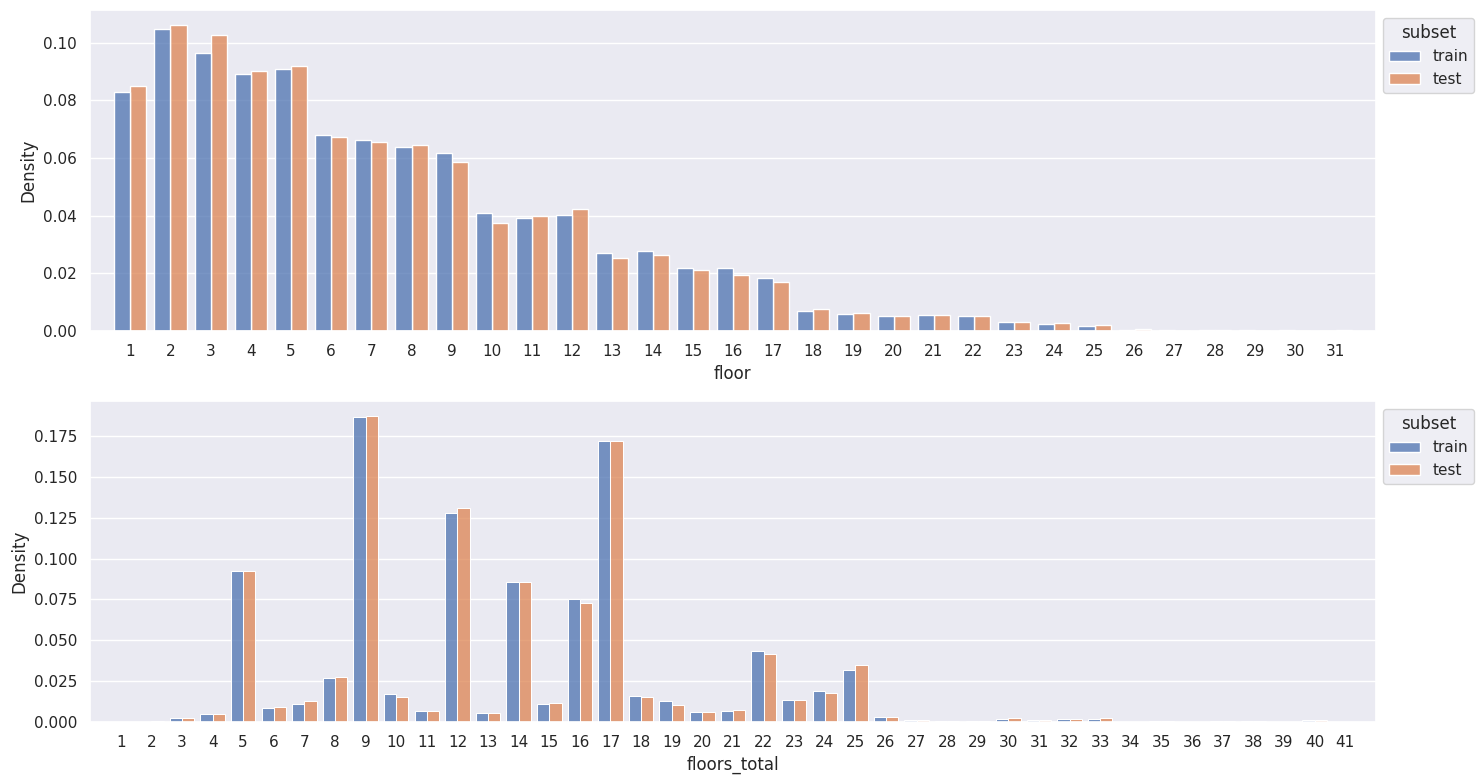

feature   hue1  hue2  significance_level  ks_2samp.pv   
0         floor  train  test                0.05     0.135198  \
1  floors_total  train  test                0.05     0.928087   

   anderson_ksamp.pv  mannwhitneyu.pv  ranksums.pv  ks_2samp.similar   
0           0.027109         0.022188     0.022557              True  \
1           0.250000         0.455655     0.459209              True   

   anderson_ksamp.similar  mannwhitneyu.similar  ranksums.similar  
0                   False                 False             False  
1                    True                  True              True

In [22]:
pivot = pd.pivot_table(df.groupby(['floor', 'floors_total'])['id'].count().reset_index(), index='floor', columns='floors_total')
pivot.columns = sorted(df['floors_total'].unique())

fig = plt.figure(figsize=(15, 10))
sns.heatmap(pivot, cmap='flare')
plt.xlabel('floors_total')
plt.show()
fig.savefig(Path(os.path.join(env_vars.eda_artifacts_dir, 'floor_floors_total_heatmap.png')), bbox_inches='tight')

custom_hist_multiplot(data=df, columns=['floor', 'floors_total'], hue='subset', features_kind='cat', cat_orient='v')
compare_distributions(data=df, features=['floor', 'floors_total'], hue='subset', are_categorical=False)

1. The distribution for both features is a discrete one.
2. The distribution for both features is similar if to compare train and test subsets (according to the histograms and most of tests)
3. The distribution of the floors_total has distinct peaks: 5, 9, 12, 14, 16, 17.
4. The distribution of floor is skewed to the left - it is more likely to find a flat with a floor from 1 to 9 (9 total floors is the peak value)
5. The distribution of floor for different values of floors_total is more or less uniform for most cases.

### rooms, building_type_int, has_elevator, is_apartment

In [23]:
df['is_apartment'].unique()

array([False,  True])

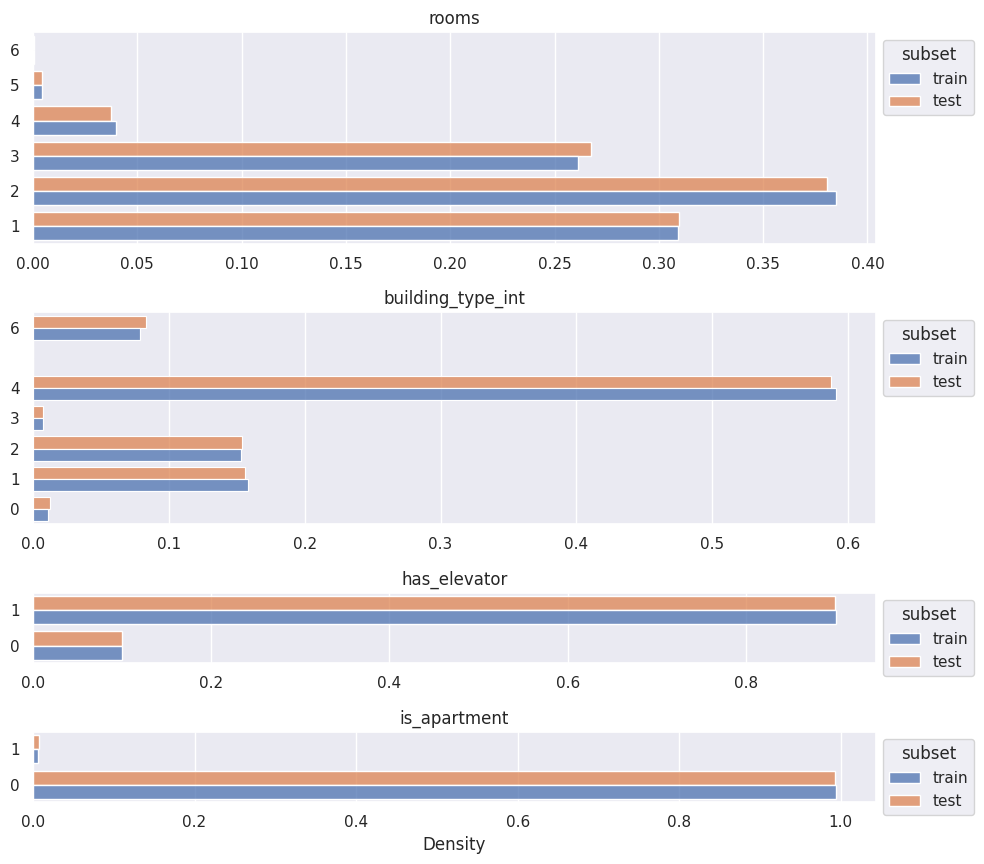

feature   hue1  hue2  significance_level  chi2_contingency.pv   
0              rooms  train  test                0.05             0.475768  \
1  building_type_int  train  test                0.05             0.450330   
2       has_elevator  train  test                0.05             0.955466   
3       is_apartment  train  test                0.05             0.597130   

   chi2_contingency_likelihood.pv  chi2_contingency.similar   
0                        0.471212                      True  \
1                        0.459146                      True   
2                        0.955474                      True   
3                        0.600060                      True   

   chi2_contingency_likelihood.similar  
0                                 True  
1                                 True  
2                                 True  
3                                 True

In [24]:
cols = ['rooms', 'building_type_int', 'has_elevator', 'is_apartment']
custom_hist_multiplot(data=df, columns=cols, hue='subset', features_kind='cat', cat_orient='h')
compare_distributions(data=df, features=cols, hue='subset', are_categorical=True)

1. The distribution for all considered columns is similar for both train and test subsets
2. It is more likely to find a flat with a very common number of 2 rooms. It is quite rare to find a flat with more than 3 rooms
3. The most popular building_type is 4, while types 0 and 3 are rare
4. Most flats are located in buildings with an elevator
5. Unsurprisingly, apartments are very rare
6. Flats with more than 4 rooms are also rare

## 2.3. Target feature analysis

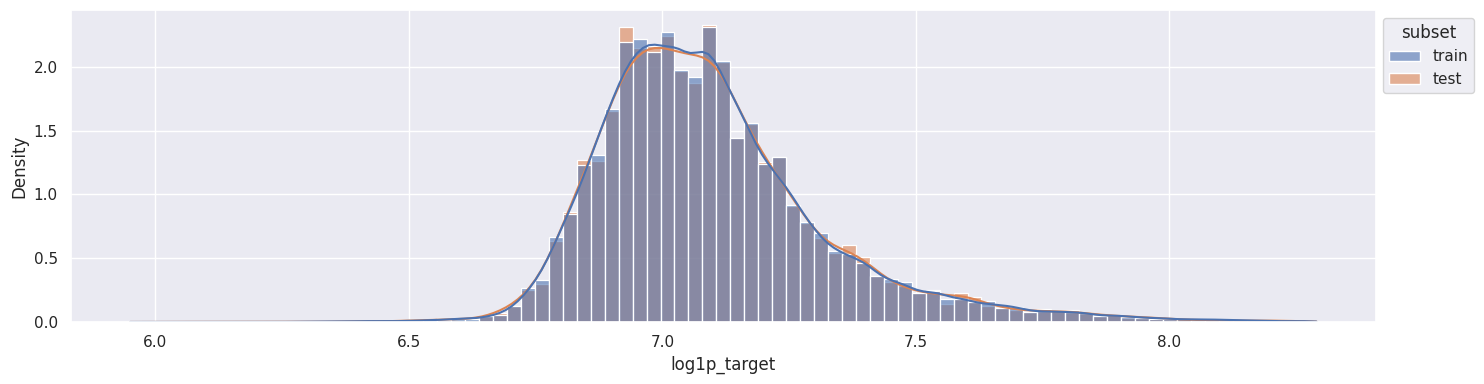

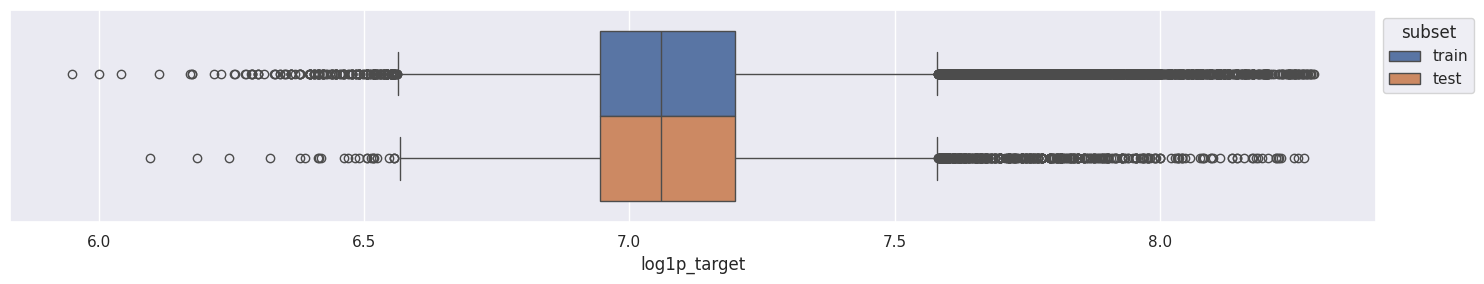

feature   hue1  hue2  significance_level  ks_2samp.pv   
0  log1p_target  train  test                0.05     0.999411  \

   anderson_ksamp.pv  mannwhitneyu.pv  ranksums.pv  ks_2samp.similar   
0               0.25         0.897535     0.897537              True  \

   anderson_ksamp.similar  mannwhitneyu.similar  ranksums.similar  
0                    True                  True              True

In [25]:
custom_hist_multiplot(data=df, columns=[config['target_col']], hue='subset', features_kind='num')
custom_box_multiplot(data=df, columns=[config['target_col']], hue='subset')
compare_distributions(data=df, features=[config['target_col']], hue='subset', are_categorical=False)

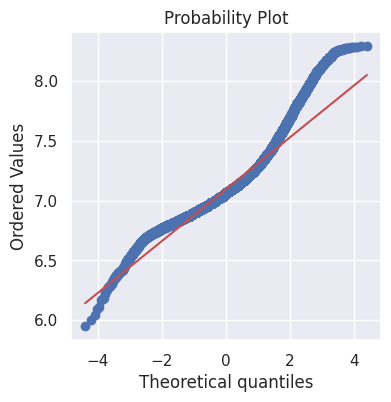

In [26]:
fig = plt.figure(figsize=(4, 4))
_ = stats.probplot(df[config['target_col']], dist="norm", plot=plt)
plt.show()
fig.savefig(Path(os.path.join(env_vars.eda_artifacts_dir, 'target_col_qqplot.png')), bbox_inches='tight')

1. The distribution is close to be symmetrical, although it is not normal according to the QQ-plot  
    (tests were not considered since there are a lof of observations in the data)
2. The distribution is similar for both train and test subsets

## 2.4. Target feature vs other features

### Numerical non-discrete features

In [40]:
num_cols = [
    "kitchen_area",
    "living_area",
    "total_area",
    "build_year",
    'flats_count',
    'ceiling_height',
    'latitude',
    'longitude',
]
num_cols2 = num_cols[:-2]

  0%|          | 0/6 [00:00<?, ?it/s]

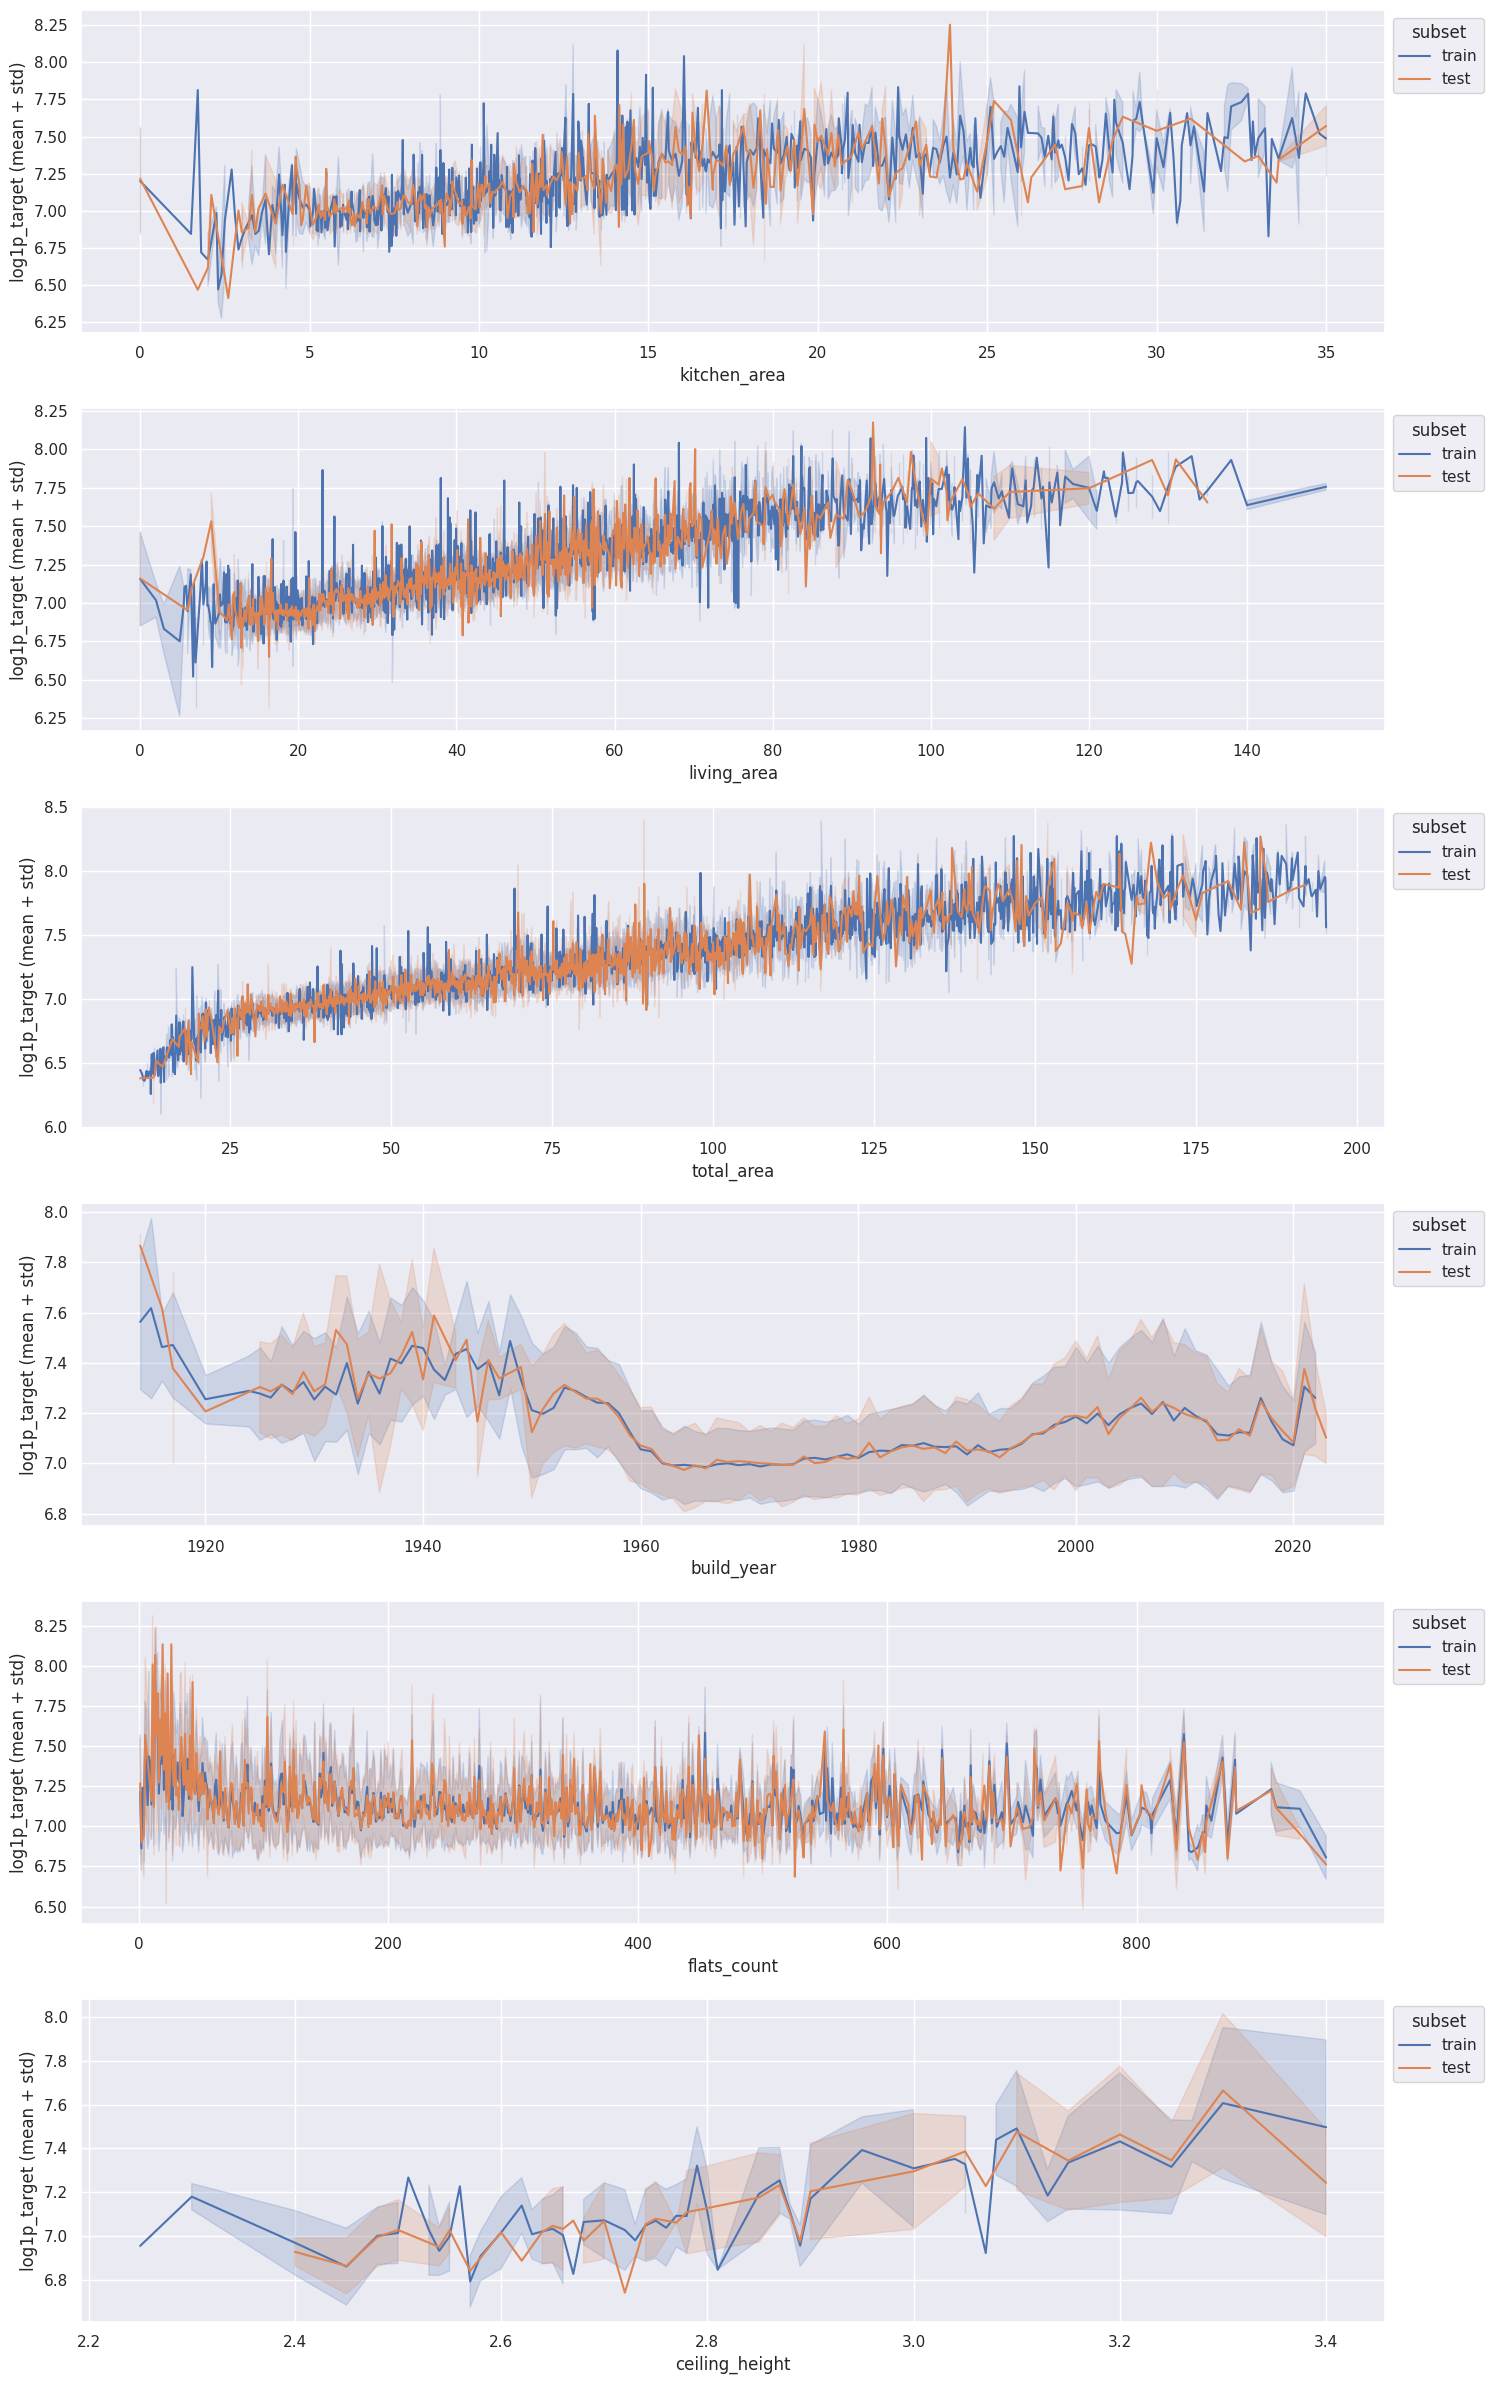

In [41]:
fig, axs = plt.subplots(len(num_cols2), figsize=(15, 4 * len(num_cols2)))

for it, col in enumerate(tqdm(num_cols2)):

    sns.lineplot(data=df, y=config['target_col'], x=col, hue='subset', ax=axs[it], errorbar='sd')
    sns.move_legend(axs[it], "upper left", bbox_to_anchor=(1, 1))
    axs[it].set_ylabel(f"{config['target_col']} (mean + std)")
fig.tight_layout()
plt.show()
fig.savefig(Path(os.path.join(env_vars.eda_artifacts_dir, 'target_col_lineplots_with_num_feats.png')), bbox_inches='tight')

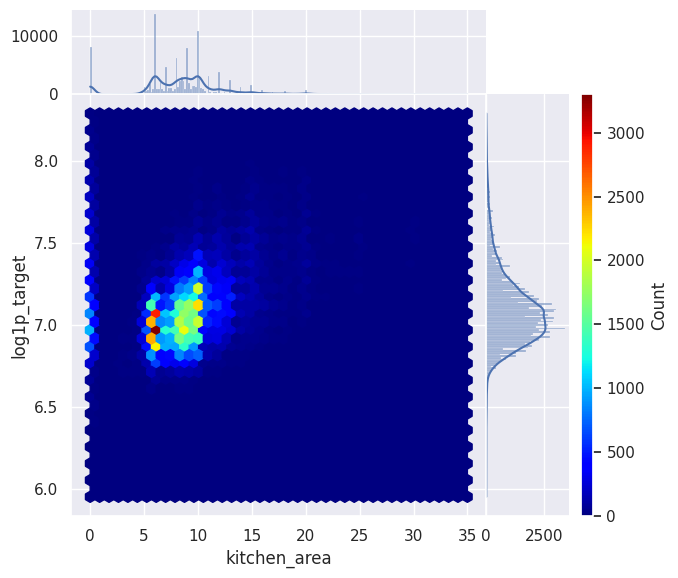

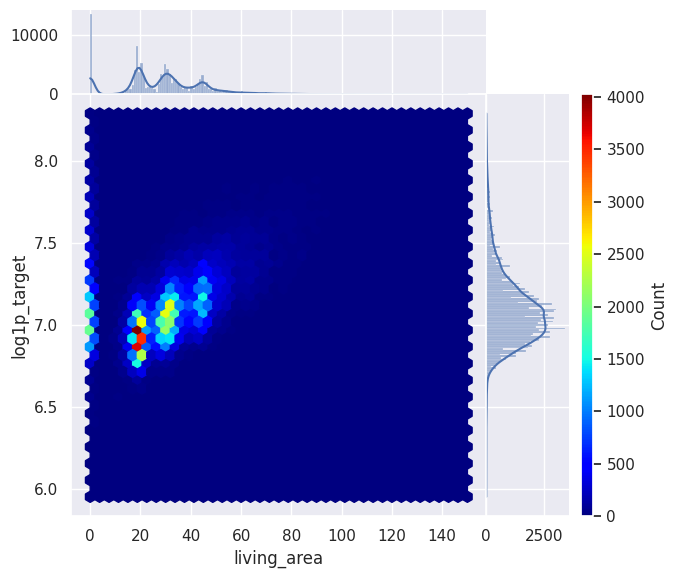

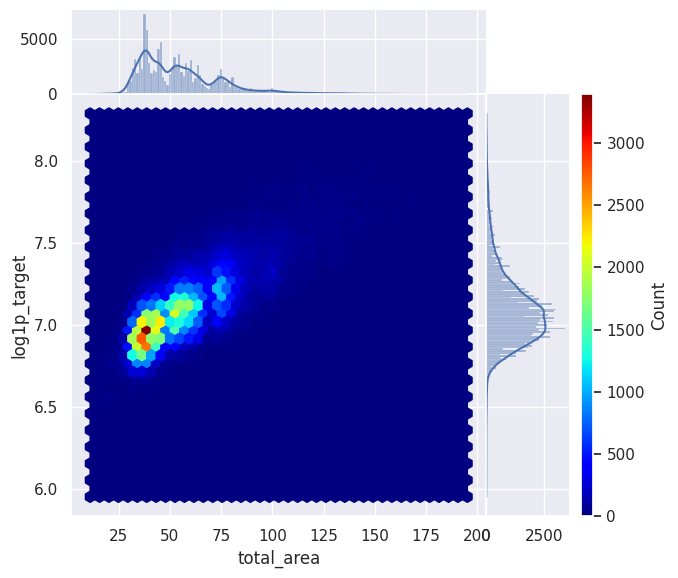

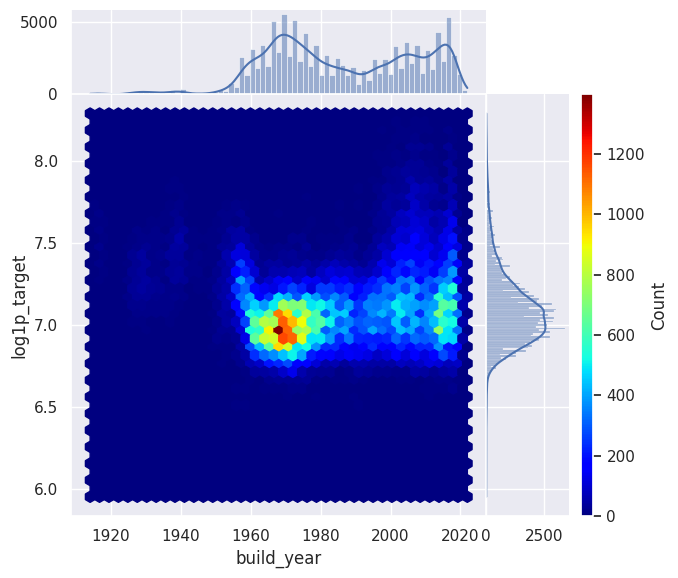

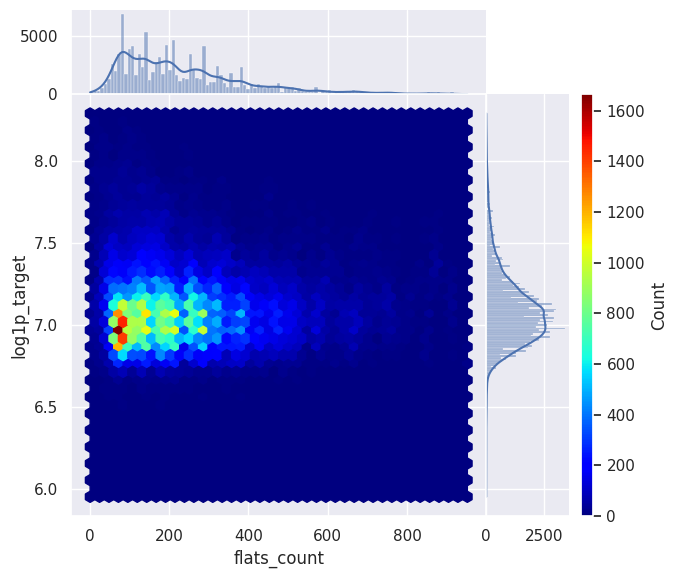

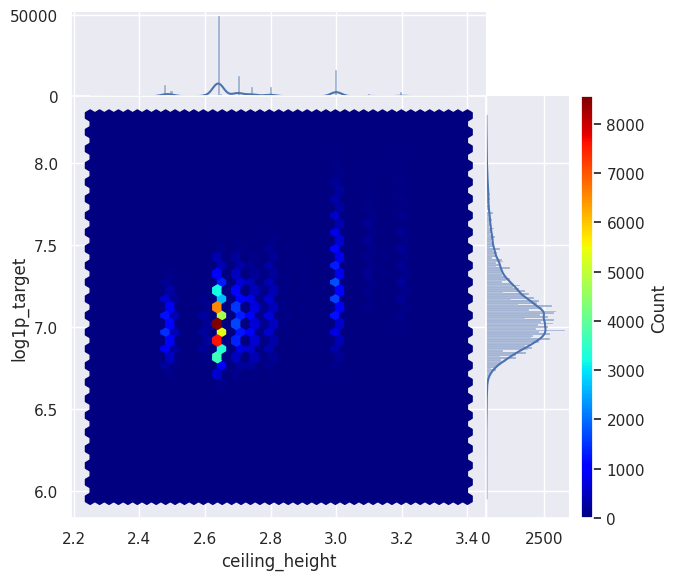

In [42]:
for col in num_cols2:
    plot = sns.jointplot(
        data=df.query('subset == "train"'),
        x=col,
        y=config["target_col"],
        kind="hex",
        marginal_kws={"kde": True},
        marginal_ticks=True,
        cmap='jet',
        gridsize=40,
    )
    plot.figure.subplots_adjust(hspace=0, wspace=0)
    pos_right_marginal = plot.ax_marg_y.get_position()
    cbar_ax = plot.figure.add_axes([pos_right_marginal.x1 + 0.02, pos_right_marginal.y0, 0.02, pos_right_marginal.height])
    cbar = plot.figure.colorbar(plot.ax_joint.collections[0], cax=cbar_ax)
    cbar.set_label('Count')
    plt.show()
    plot.savefig(Path(os.path.join(env_vars.eda_artifacts_dir, f'{col}_and_target_jointplot.png')), bbox_inches='tight')

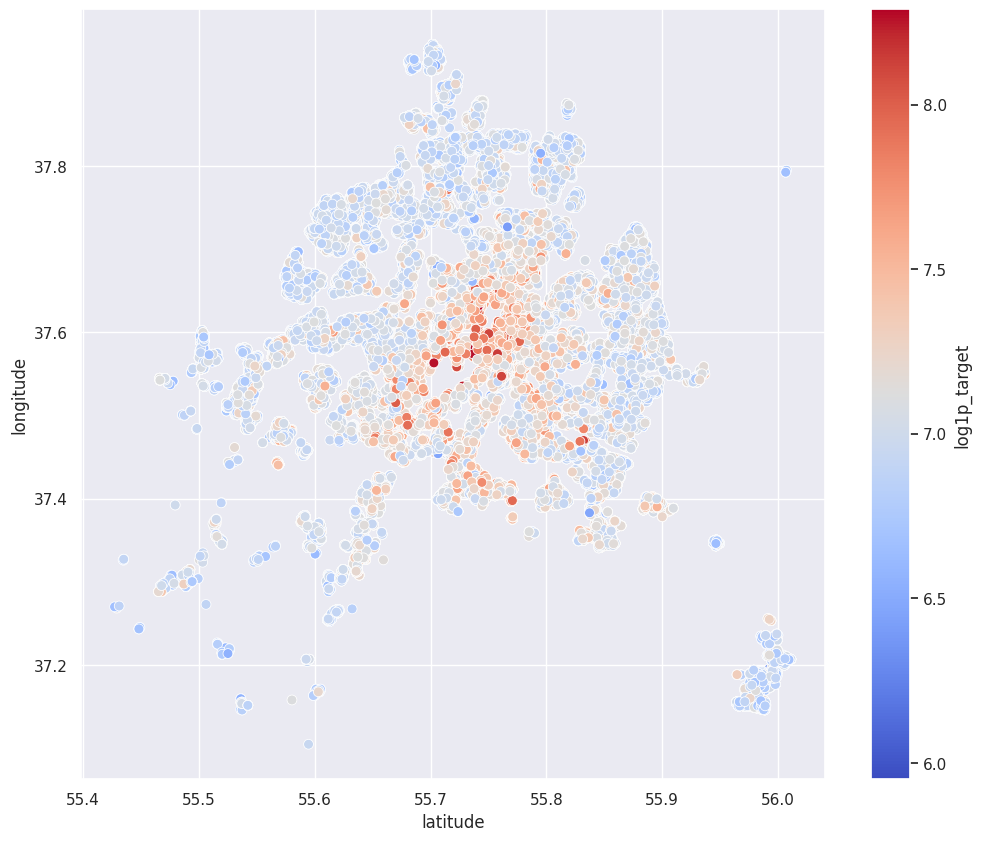

In [30]:
df2 = df.query('subset == "train"')[['latitude', 'longitude', config['target_col']]].copy()
df2.drop_duplicates(inplace=True)

fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(data=df2, x='latitude', y='longitude', hue=config['target_col'], palette='coolwarm', s=50, ax=ax, legend=False)
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(df2[config['target_col']].min(), df2[config['target_col']].max()))
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label(config['target_col'])
plt.show()
fig.savefig(Path(os.path.join(env_vars.eda_artifacts_dir, 'target_col_coordinates_plot.png')), bbox_inches='tight')

1. The distribution for area features vs the target feature is similar to y=k*x, which is a good sign since  
    the more the area, the more the price.
2. If to consider build_year, 2 tendencies can be observed:
- for build_year <= 1960: the older the building, the more the price
- for build_year > 1960: the newer the building, the price is at least the same or can be higher
3. flats_count does not really affect the price, although at least the price tends to not decrease with the increase of flats_count
4. The most expensive flats are mostly located in the center of the city with two small groups in the south-west and south-east parts
5. The price tends to be higher for the flats with a higher ceiling

### Numerical discrete features

In [31]:
num_discrete_cols = [
    "floor",
    "floors_total",
    "rooms",
]

  0%|          | 0/3 [00:00<?, ?it/s]

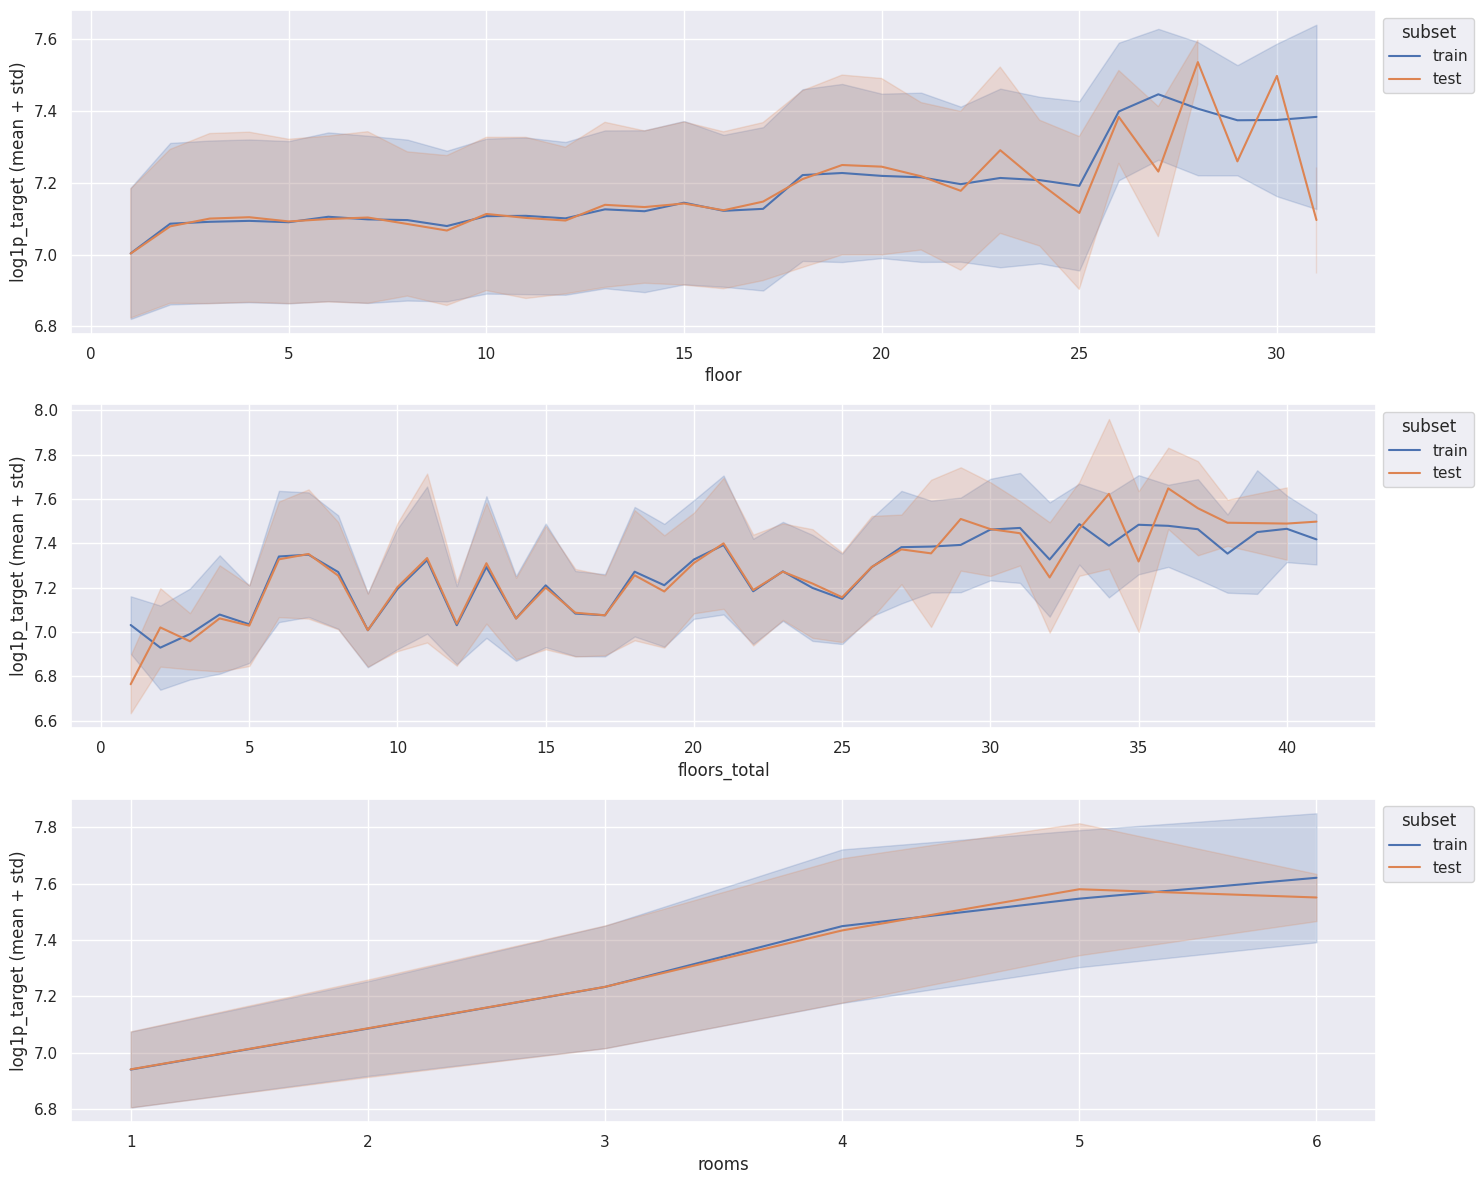

In [32]:
fig, axs = plt.subplots(len(num_discrete_cols), figsize=(15, 4 * len(num_discrete_cols)))

for it, col in enumerate(tqdm(num_discrete_cols)):

    sns.lineplot(data=df, y=config['target_col'], x=col, hue='subset', ax=axs[it], errorbar='sd')
    sns.move_legend(axs[it], "upper left", bbox_to_anchor=(1, 1))
    axs[it].set_ylabel(f"{config['target_col']} (mean + std)")
fig.tight_layout()
plt.show()
fig.savefig(Path(os.path.join(env_vars.eda_artifacts_dir, 'target_col_lineplots_with_num_discrete_feats.png')), bbox_inches='tight')

1. The price is higher for the flats with more rooms
2. The price tends to be higher for the flats with a higher floor or floors_count, although the dependency is not monotonous   
    (there are some fluctuations)

### Categorical features

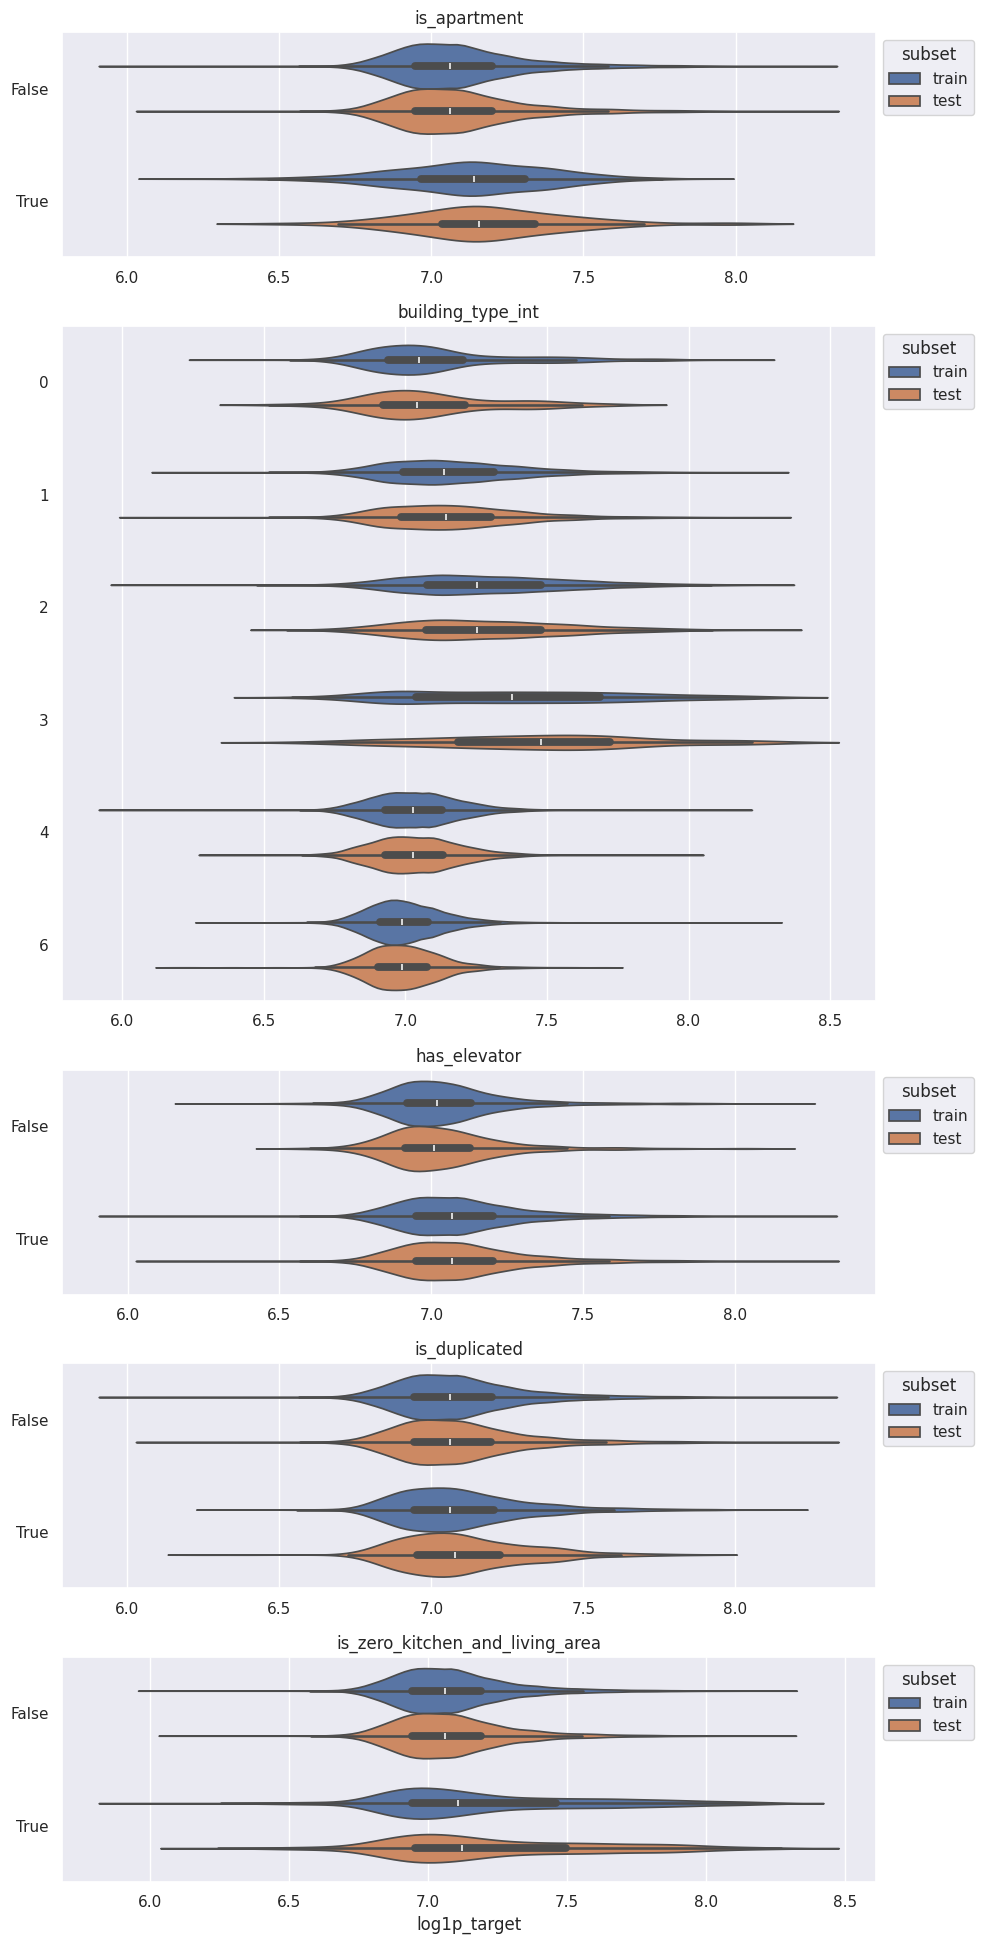

2024-09-18 21:25:59,722 - mlflow_project - INFO - custom_violin_multiplot saved to ../artifacts/eda/target_col_and_cat_feats_violinplot.png


In [33]:
cat_cols = [
    "is_apartment",
    "building_type_int",
    "has_elevator",
    "is_duplicated",
    "is_zero_kitchen_and_living_area",
]
custom_violin_multiplot(
    data=df,
    x=config["target_col"],
    columns=cat_cols,
    hue='subset',
    k=1.4,
    savepath=Path(
        os.path.join(
            env_vars.eda_artifacts_dir,
            "target_col_and_cat_feats_violinplot.png",
        )
    ),
)


1. The apartments are slightly more expensive with also a lower variance of the price,  
which correlates with the fact that the apartments are of a better quality
2. building_type categories can be sorted by the price in the following order: 6, 4, 0, 1, 2, 3.  
    This means that quite rare buildings of type 3 have more expensive flats, while most common buildings of type 4 have cheaper flats
3. Buildings with elevators have more expensive flats, although the variance of the price is higher
4. is_duplicated does not affect the price expect for a slightly lower variance in the price
5. Properites with both 0 kitchen area and living are have a slightly higher price with higher variance

### Correlation analysis

interval columns not set, guessing: ['kitchen_area', 'living_area', 'total_area', 'build_year', 'flats_count', 'ceiling_height', 'latitude', 'longitude', 'floor', 'floors_total', 'rooms', 'building_type_int', 'log1p_target']


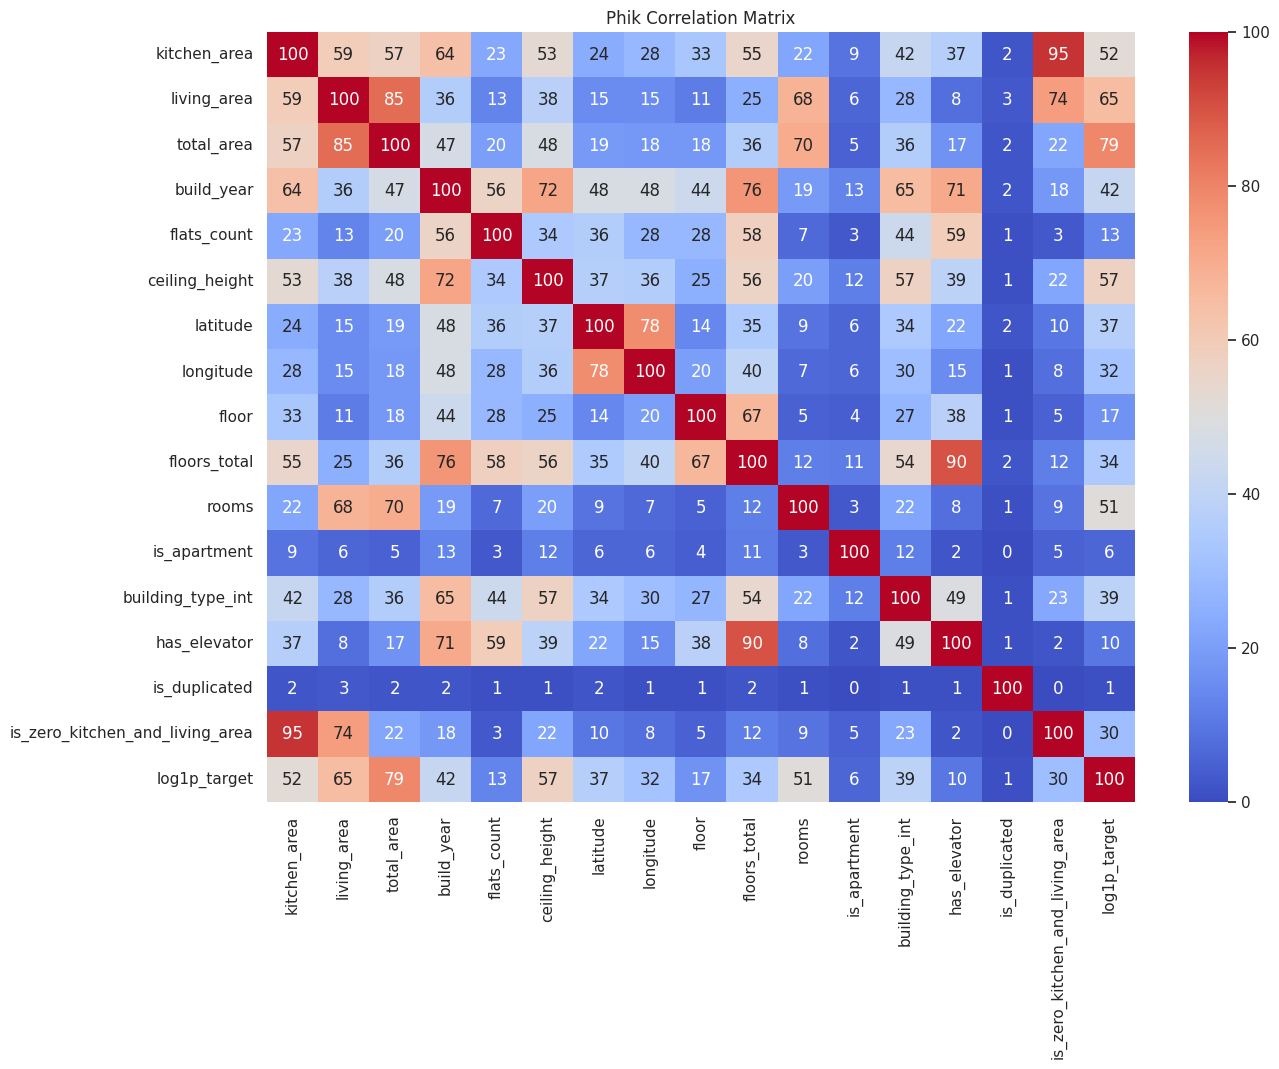

In [34]:
phik_matrix = df.query("subset == 'train'")[num_cols + num_discrete_cols + cat_cols + [config['target_col']]].phik_matrix()

fig = plt.figure(figsize=(14, 10))
matrix = sns.heatmap((phik_matrix*100).astype(int), annot=True, cmap='coolwarm', fmt='d')
plt.title("Phik Correlation Matrix")
plt.show()
fig.savefig(Path(os.path.join(env_vars.eda_artifacts_dir, 'phik_correlation_matrix.png')), bbox_inches='tight')

The following high correlations with a target feature can be observed:
- total_area, kitchen_area, living_area: very obvious correlation, the more the area the higher the price (see also the graphs earlier)
- ceiling_height: the same idea (see also the graphs earlier)
- rooms: the same idea (see also the graphs earlier)

Here are some other interesting observations:
- high correlation between has_elevator and floors_total: high enough builidings always have elevators
- high correlation between build_year and floors_total: newer buildings usually higher with more floors than older ones
- high correlation between build_year and ceiling_height: too old buildings had higher ceilingsa and after that the ceiling height significantly decreased
- high correlation between total_area and rooms: a very obvious correlation
- is_duplicated and is_apartment features have very little effect on other features

## 2.5. Conclusions on EDA

The following important notes can be made:
1. The following features have a high correlation with the target feature:
- total_area, ceiling_height, living_area, kitchen_area, rooms
2. The following features have a very low correlation with the target feature:
- is_duplicated, is_apartment
3. An average flat can be described as follows:
- located within Moscow
- located in a building built in the 70s-80s with a typical characteristics of the residential buildings built in that period
- ceiling height is about 2.6-2.7m
- number of floors is about 14-17
- total_area is about 52-57 $m^2%$ with half of the total area being the living area
- price is about 15 million rubles
4. The distributon of the target feature is close to be normal, which is a good sign.  
5. The distribution of all features is similar if to compare train and test subsets  
6. The price is higher, if:
- the area is larger
- the ceiling is higher
- the number of rooms is larger
- the flat is closer to the center of Moscow
- the building is too old or built in the near past
- the building type is 3
- it is an apartment
7. A flat is rare if:
- it is an apartment
- the building type is 0 or 3
- the number of rooms is larger than 4
- the building is too old or too high
8. There is a significant amount of flats with 0 kitchen and living areas.  
These properties are probably used for commercial purposes.
9. It is a good idea to create the following features:
- the distance from the center of Moscow to the flat
- the distance from the nearest metro station to the flat
- a feature which would indicate whether the value is 0 for both living_area and kitchen_area

## 2.6. Logging artefacts via MLflow

First off, let's save tests results, which compare the distributions on the train and test subsets

In [35]:
df2 = compare_distributions(data=df, features=num_cols+num_discrete_cols+[config['target_col']], hue='subset', are_categorical=False)
df2.to_csv(os.path.join(env_vars.eda_artifacts_dir, 'train_test_distr_comparison_for_num_feats.csv'), index=False)

df2 = compare_distributions(data=df, features=cat_cols, hue='subset', are_categorical=True)
df2.to_csv(os.path.join(env_vars.eda_artifacts_dir, 'train_test_distr_comparison_for_cat_feats.csv'), index=False)

Let's move the current notebook to the artifacts directory

In [53]:
os.system(f"cp {os.path.join(os.getcwd(), '2_model_improvement.ipynb')} {os.path.join(env_vars.eda_artifacts_dir, 'eda.ipynb')}")

0

Saving main statistics of the numerical features

In [37]:
df2 = df.query('subset == "train"')[num_cols+num_discrete_cols+[config['target_col']]].describe()
df2.to_csv(os.path.join(env_vars.eda_artifacts_dir, 'num_feats_statistics_train.csv'), index=False)

df2 = df.query('subset == "test"')[num_cols+num_discrete_cols+[config['target_col']]].describe()
df2.to_csv(os.path.join(env_vars.eda_artifacts_dir, 'num_feats_statistics_test.csv'), index=False)

In [38]:
counts = {}
for subset in ['train', 'test']:
    counts[subset] = {}
    for col in cat_cols:
        d = df.query(f'subset == "{subset}"')[col].value_counts().reset_index().to_dict()
        d[col] = dict([(v, d['count'][k]) for (k, v) in d[col].items()])
        del d['count']
        counts[subset][col] = d[col]
save_yaml(data=counts, path=Path(os.path.join(env_vars.eda_artifacts_dir, 'cat_feats_statistics.yaml')))

2024-09-18 21:26:15,537 - mlflow_project - INFO - Dictionary has been saved to YAML file ../artifacts/eda/cat_feats_statistics.yaml


Saving plots that can be grouped together

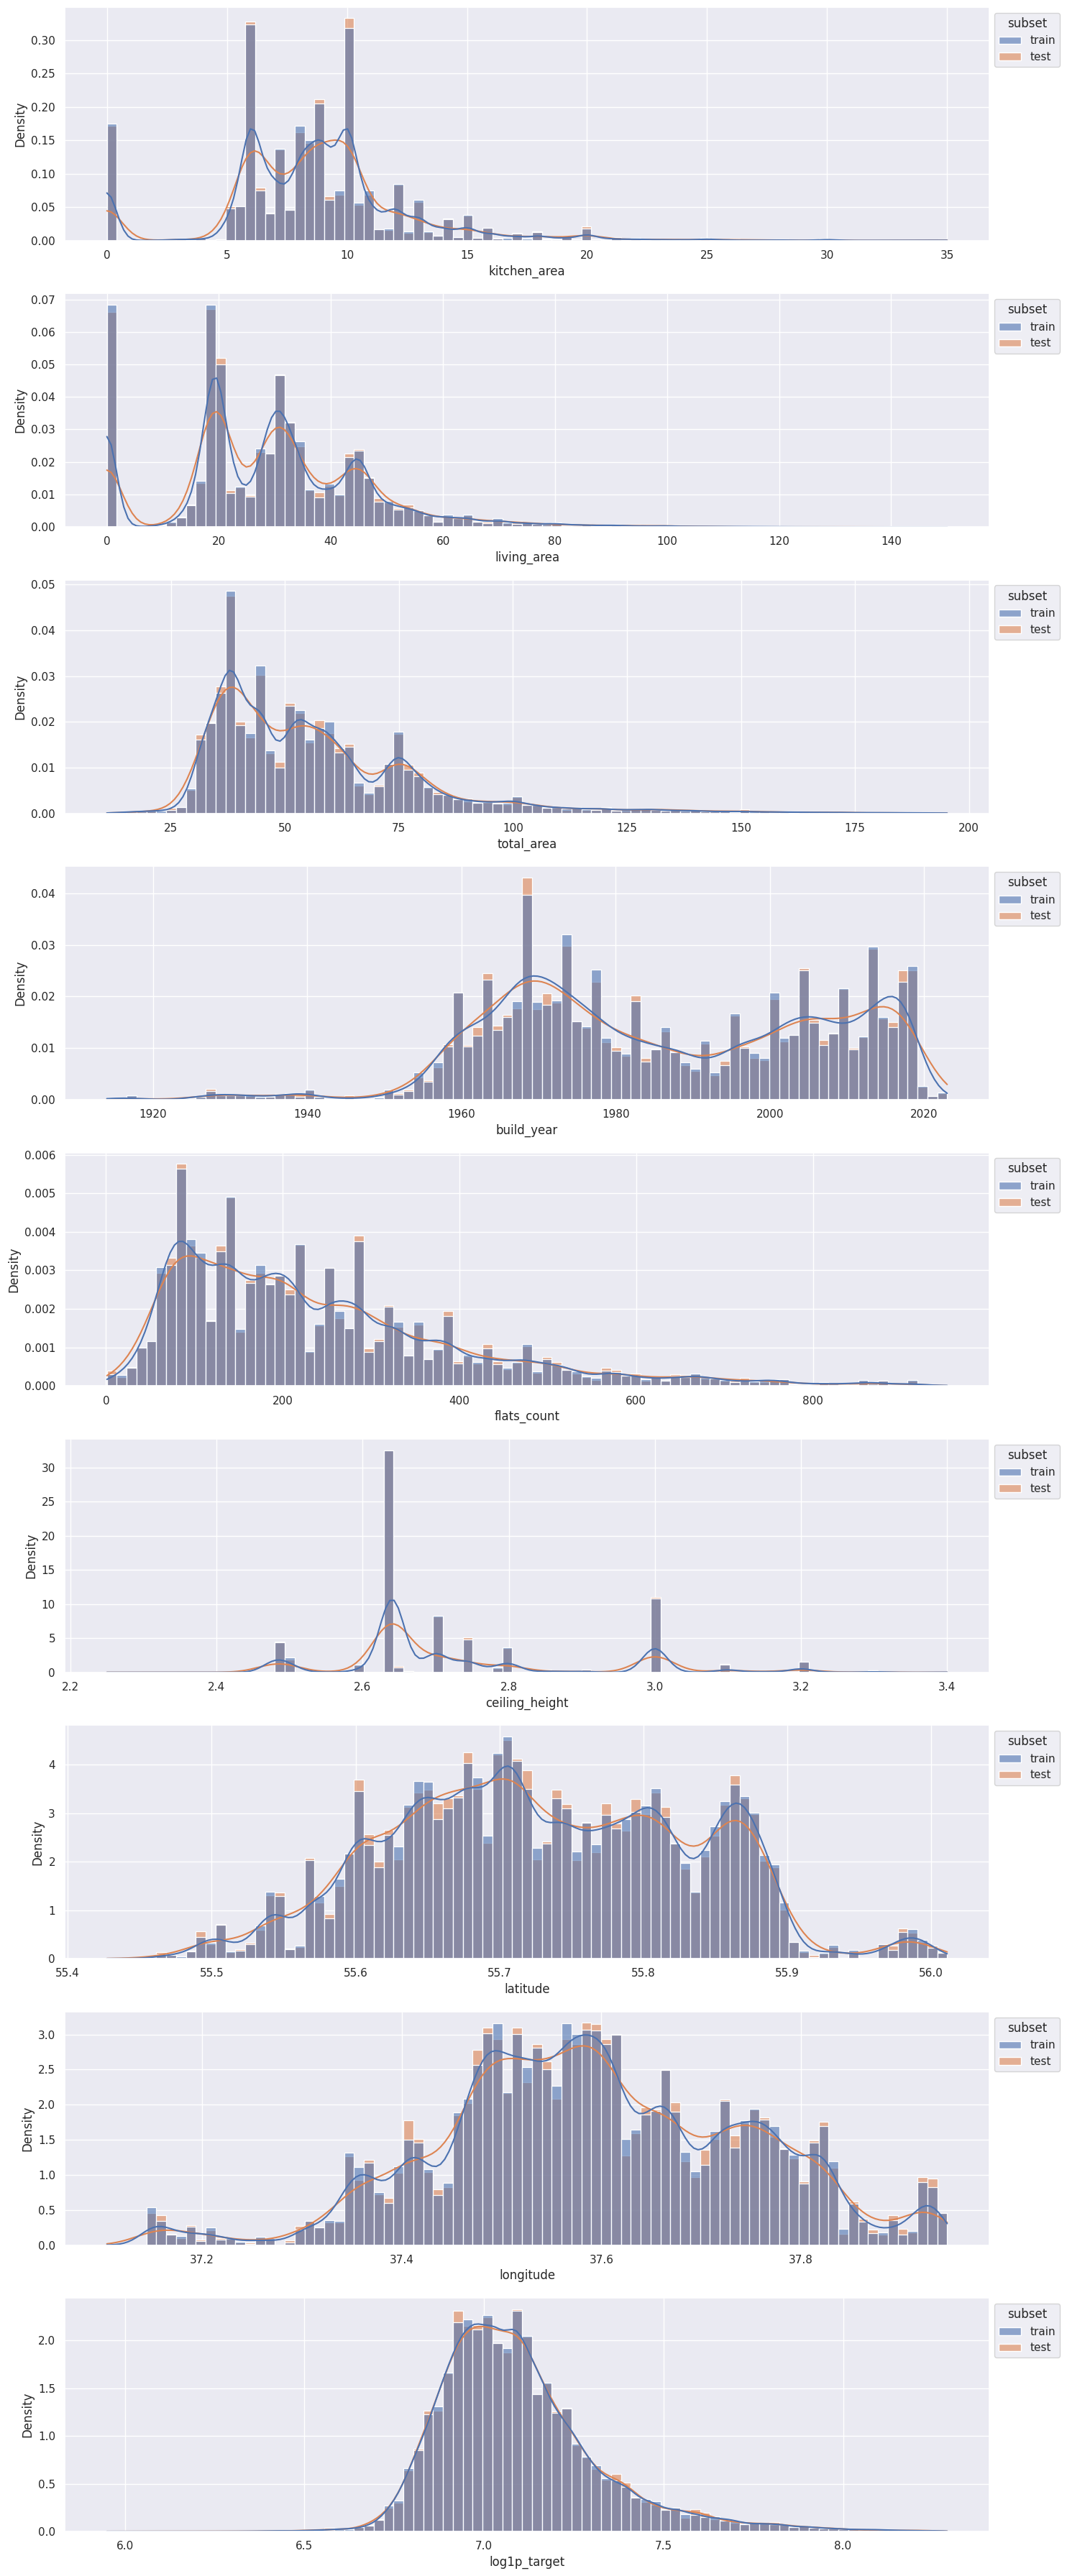

2024-09-18 21:26:31,075 - mlflow_project - INFO - custom_hist_multiplot saved to ../artifacts/eda/num_feats_histplot.png


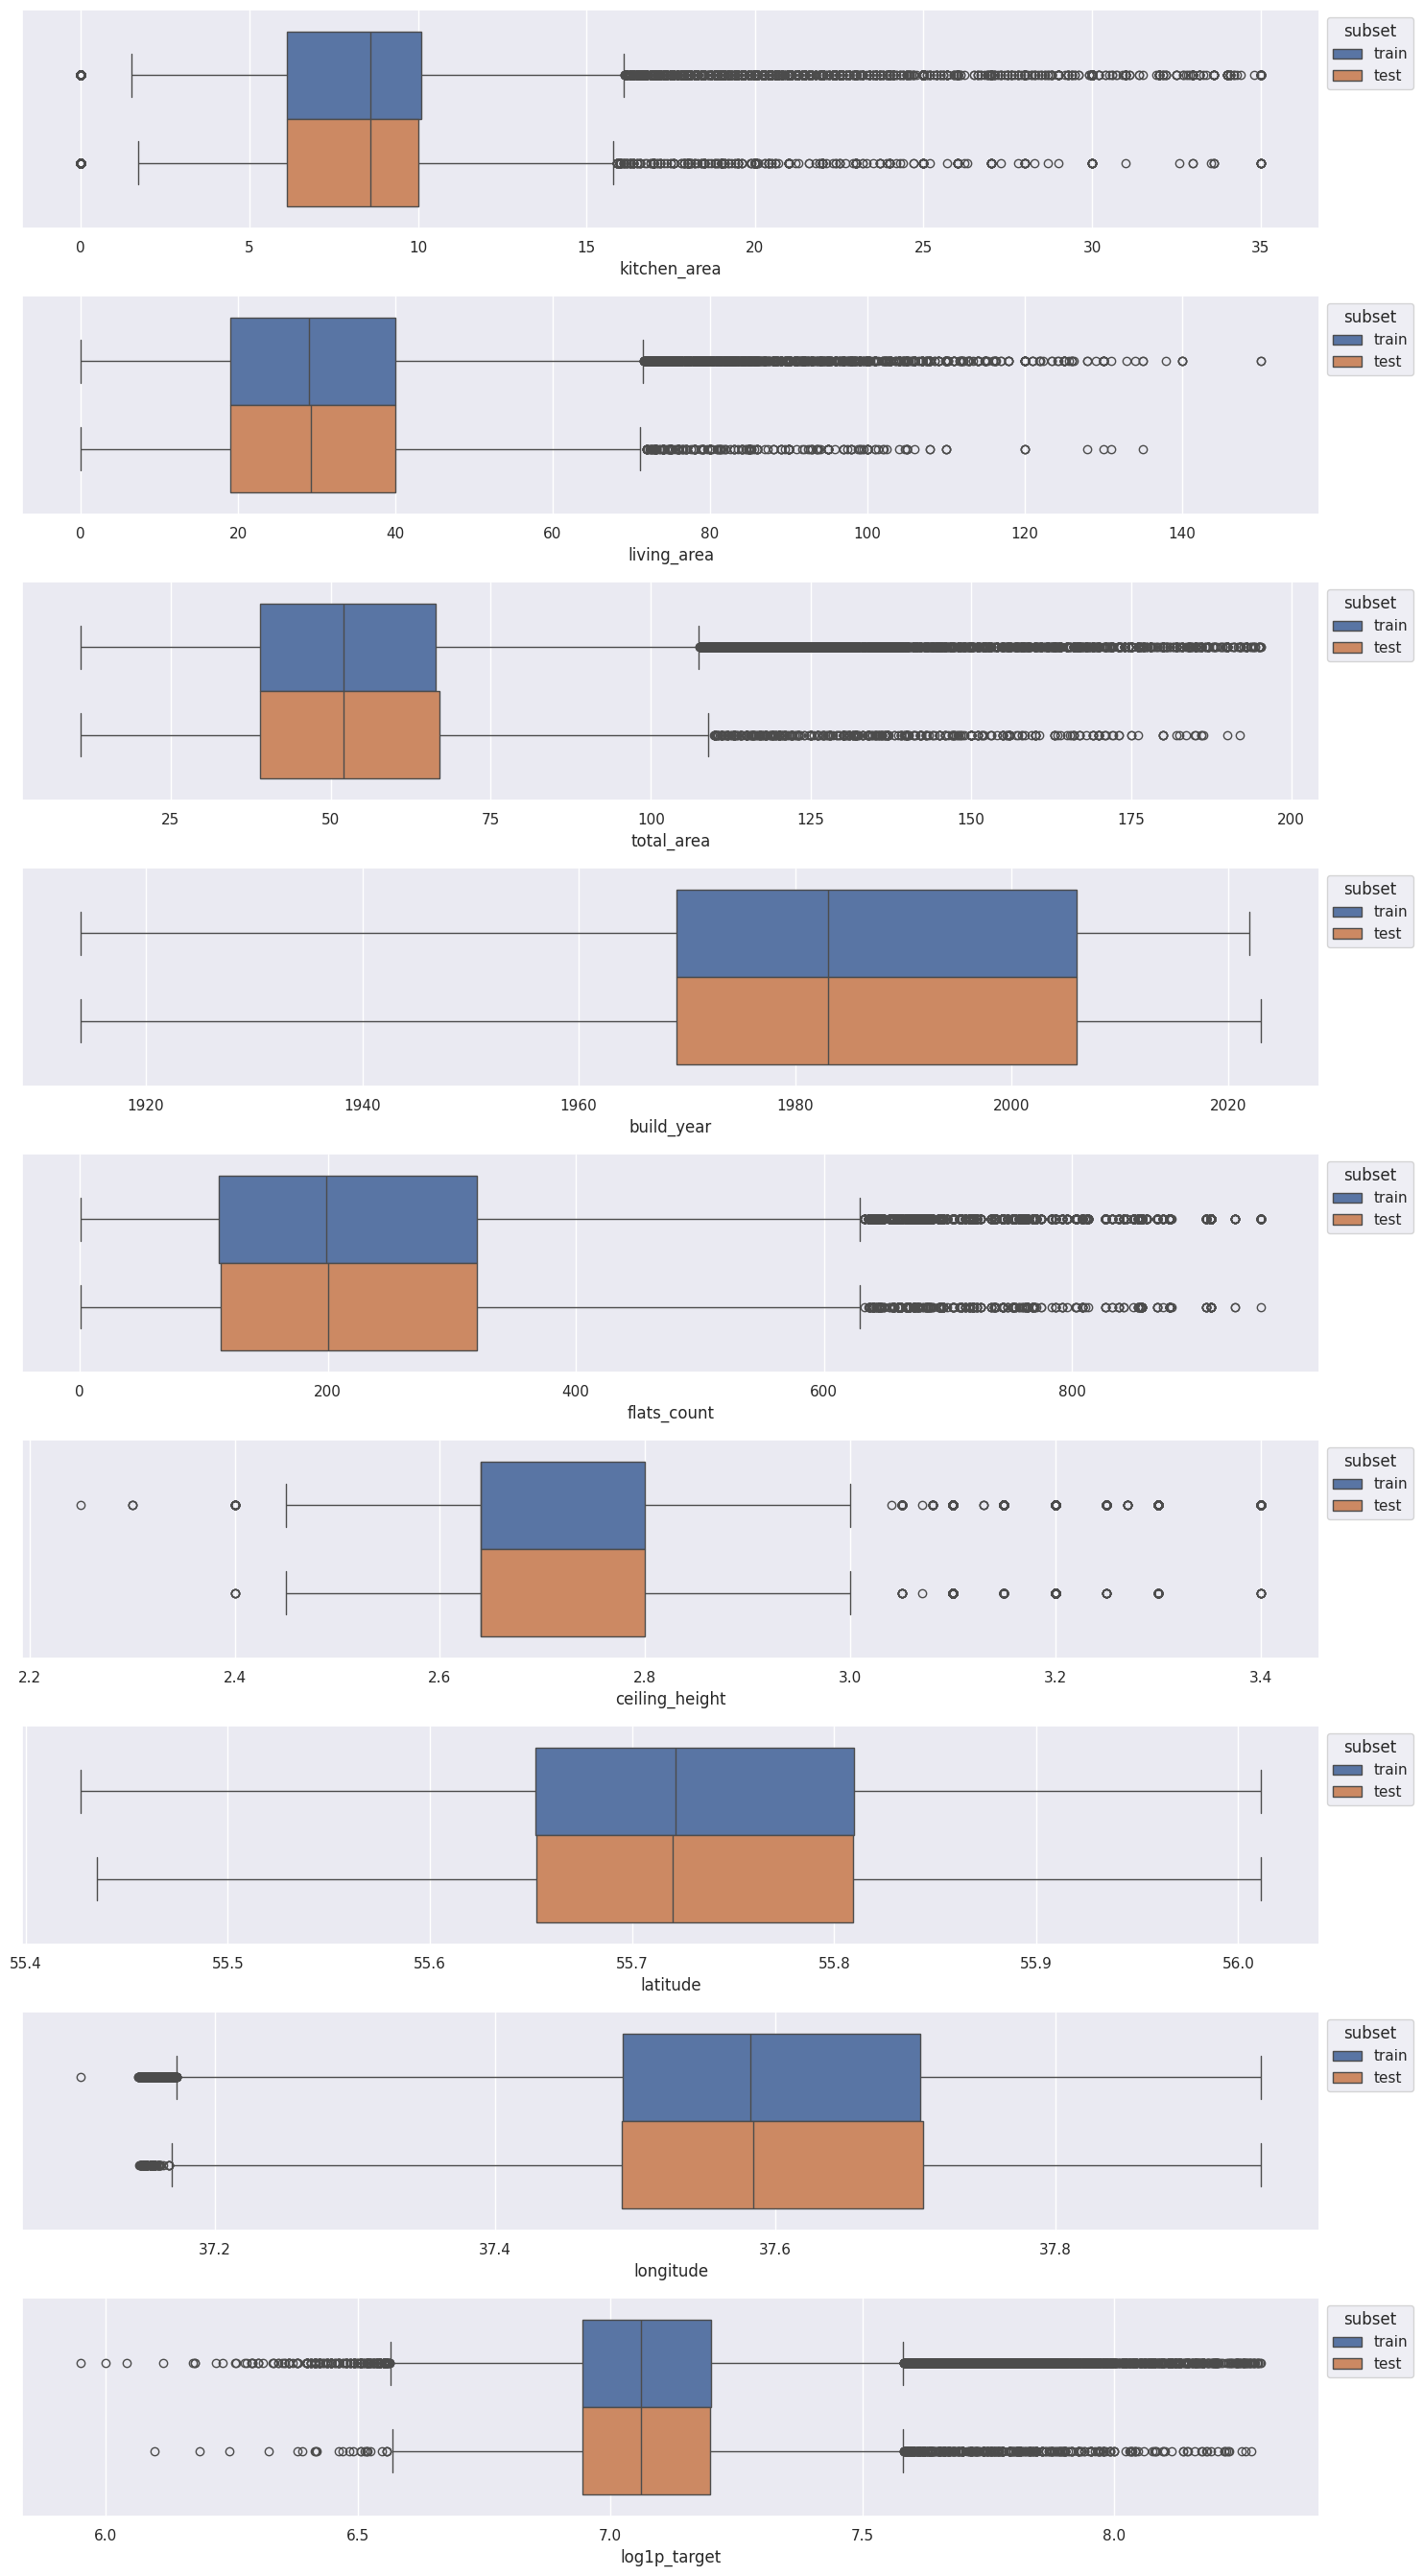

2024-09-18 21:26:37,889 - mlflow_project - INFO - custom_box_multiplot saved to ../artifacts/eda/num_feats_boxplot.png


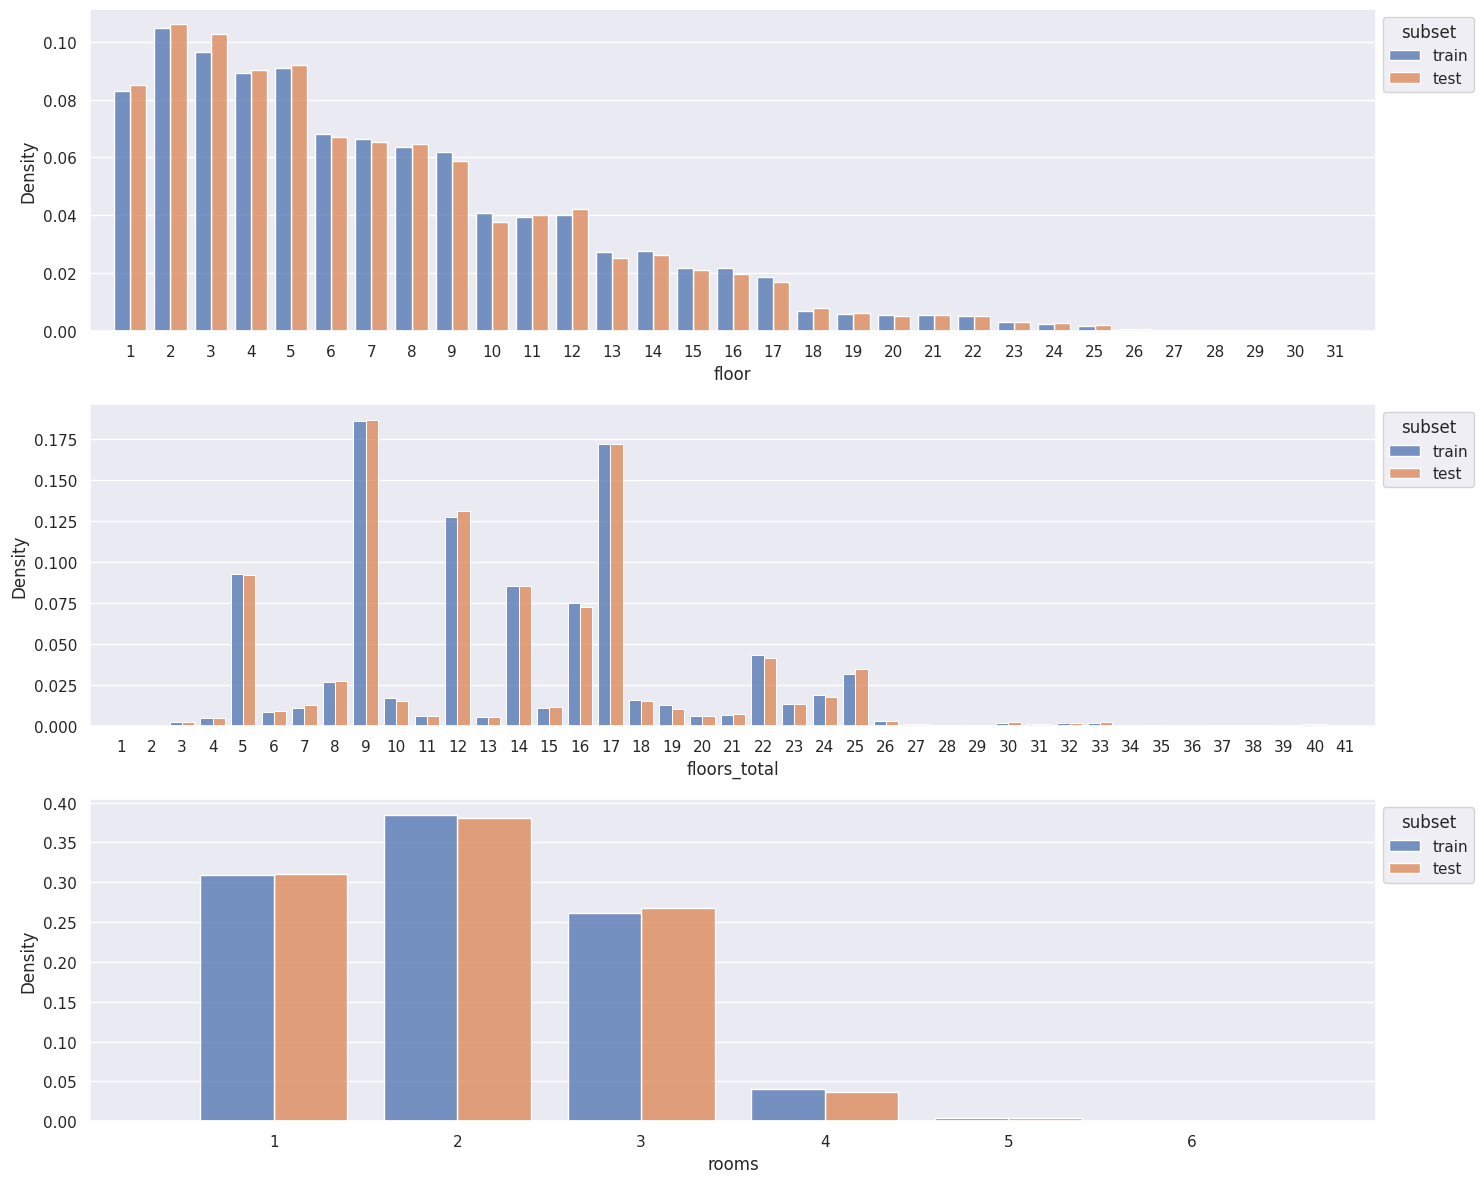

2024-09-18 21:26:42,495 - mlflow_project - INFO - custom_hist_multiplot saved to ../artifacts/eda/num_discrete_feats_histplot.png


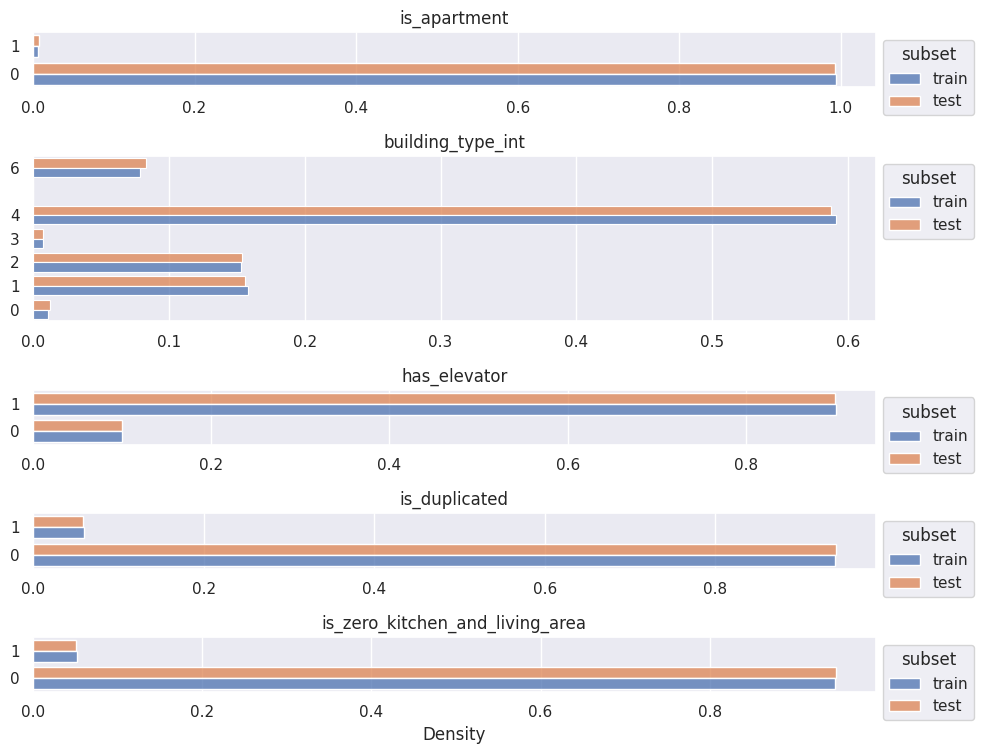

2024-09-18 21:26:45,154 - mlflow_project - INFO - custom_hist_multiplot saved to ../artifacts/eda/cat_feats_histplot.png


In [39]:
custom_hist_multiplot(
    data=df,
    columns=num_cols + [config["target_col"]],
    hue="subset",
    features_kind="num",
    savepath=Path(
        os.path.join(
            env_vars.eda_artifacts_dir, "num_feats_histplot.png"
        )
    ),
)

custom_box_multiplot(
    data=df,
    columns=num_cols + [config["target_col"]],
    hue="subset",
    savepath=Path(
        os.path.join(
            env_vars.eda_artifacts_dir, "num_feats_boxplot.png"
        )
    ),
)

custom_hist_multiplot(
    data=df,
    columns=num_discrete_cols,
    hue="subset",
    features_kind="cat",
    cat_orient="v",
    savepath=Path(
        os.path.join(
            env_vars.eda_artifacts_dir, "num_discrete_feats_histplot.png"
        )
    ),
)

custom_hist_multiplot(
    data=df,
    columns=cat_cols,
    hue="subset",
    features_kind="cat",
    cat_orient="h",
    savepath=Path(
        os.path.join(
            env_vars.eda_artifacts_dir,
            "cat_feats_histplot.png",
        )
    ),
)

Let's log all the artefacts

In [54]:
experiment_id = get_experiment_id(experiment_name=config['experiment_name'], client=client)

with mlflow.start_run(run_name=RUN_NAME_EDA, experiment_id=experiment_id) as run:

    mlflow.log_artifacts(env_vars.eda_artifacts_dir, 'eda')

    logger.info('EDA artifacts have been logged')

2024-09-18 21:40:15,426 - mlflow_project - INFO - Experiment 'flat_price_prediction' exists


2024-09-18 21:40:16,576 - mlflow_project - INFO - EDA artifacts have been logged
